# Final project of the course Machine Learning with Python 2021

_authors: Maria Cristina Hinojosa Lee, Maarten Velghe, Daniel Borek_

##Introduction

This  project corresponds to the final task of the course Machine Learning with Python offered by the PVW-ICES. The team will take the role of data scientists for an exclusive Hotel in the Bahamas. The goal is to screen applying Russian clients. The reason is that Russian clients represent a contrasting customer segment. On one hand, they spend a high quantity of money during their stay in the hotel. On the other hand, they also cause a high cost on damages that is not recoverable for the Hotel. 
 
### Problem definition 
 
For this work the objective was to build a model that would predict the expected value for each potential client of the hotel. After this, the best 200 applications from a list of 500 potential customers needed to be generated. The client list should represent a balance between damage and profit.  
 
To be able to achieve this, different algorithms had to be used. To train them, a second data set was facilitated that contained information over former guests. This data set included variables such as profit, damage (from visits that excluded the last one), age , gender, among others. 
 
We approached the problem in two ways. The first one consisted in predicting separately the projected revenue per clients, predicting which clients would cause damage, and then predicting the amount of damage that they would cause. This information was then used to create a measurement of the expected value for each potential customer and then to generate a client list. 
 
The second approach was to treat the whole problem as a model of imbalanced classification of "good" and "bad" clients. The assumption  would be that the "good" clients are the minority. This would mean that there are limited places in the client list, so the best 200 customers from the 500 applications, need to be selected. This would make the 40 % of the  applications "good" clients, while the other 60% would represent "bad" clients.
This approach would also assume that marking a "good client" as bad, would be more costly than admiting a bad customer in the good customer list.
 
The main analysis presented in this notebook refers to the first approach.

# Import libraries

#### Install specific versions of packages that work in  google colab

In [ ]:
installed = 1 
if installed == 1:
  !pip install scikit-learn==0.24.1
  !pip install  pandas==1.1.5
  !pip install  numpy==1.19.5
  !pip install folium==0.2.1
  !pip install imgaug==0.2.5
  !pip install scikit-plot




     |████████████████████████████████| 22.3MB 38.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


     |████████████████████████████████| 71kB 4.0MB/s 
  Created wheel for folium: filename=folium-0.2.1-cp37-none-any.whl size=79810 sha256=a65f8177751227b3a7354dc2ac21e6ba65488c843bc45e6ca7f15f560e8705ec
  Stored in directory: /root/.cache/pip/wheels/b8/09/f0/52d2ef419c2aaf4fb149f92a33e0008bdce7ae816f0dd8f0c5
Successfully built folium
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 563kB 5.1MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-cp37-none-any.whl size=561439 sha256=2bd13f9fd9072c2515eb93df821daa57a137b7ec1d8a81e506feaa7b01540d6a
  Stored in directory: /root/.cache/pip/wheels/31/48/c8/ca3345e8582a078de94243996e148377ef66fdb845557bae0b
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:

import numpy as np
import pandas as pd
from matplotlib import animation as ani, pyplot as plt
import seaborn as sns #pretty graphics R style

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML
plt.style.use('seaborn-darkgrid')
import matplotlib as mpl 
import matplotlib.pyplot as plt #graphics

from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler #library for the rescaling
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from treeinterpreter import treeinterpreter as ti, utils
from sklearn import preprocessing
from sklearn import utils
from sklearn import feature_selection
from scipy import stats
from collections import defaultdict


In [ ]:
def feature_importance_regression(features, target, n_neighbors=4, random_state=None):

    cont = features.select_dtypes(include=[np.floating])
    disc = features.select_dtypes(include=[np.integer, np.bool])

    cont_imp = pd.DataFrame(index=cont.columns)
    disc_imp = pd.DataFrame(index=disc.columns)

    # Continuous features
    if cont_imp.index.size > 0:

        # Pearson correlation
        pearson = np.array([stats.pearsonr(feature, target) for _, feature in cont.iteritems()])
        cont_imp['pearson_r'] = pearson[:, 0]
        cont_imp['pearson_r_p_value'] = pearson[:, 1]

        # Mutual information
        mut_inf = feature_selection.mutual_info_regression(cont, target, discrete_features=False,
                                                           n_neighbors=n_neighbors,
                                                           random_state=random_state)
        cont_imp['mutual_information'] = mut_inf

    # Discrete features
    if disc_imp.index.size > 0:

        # F-test
        f_tests = defaultdict(dict)

        for feature in disc.columns:
            groups = [target[idxs] for idxs in disc.groupby(feature).groups.values()]
            statistic, p_value = stats.f_oneway(*groups)
            f_tests[feature]['f_statistic'] = statistic
            f_tests[feature]['f_p_value'] = p_value

        f_tests_df = pd.DataFrame.from_dict(f_tests, orient='index')
        disc_imp['f_statistic'] = f_tests_df['f_statistic']
        disc_imp['f_p_value'] = f_tests_df['f_p_value']

        # Mutual information
        mut_inf = feature_selection.mutual_info_regression(disc, target, discrete_features=True,
                                                           n_neighbors=n_neighbors,
                                                           random_state=random_state)
        disc_imp['mutual_information'] = mut_inf

    return cont_imp, disc_imp 

def get_meaningful_variables(data_train, feature = 'outcome_damage_inc' ):
  X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_train[feature], test_size=0.2,  random_state=48)
  cont_imp, disc_imp = feature_importance_regression(X_train.reset_index(drop=True), y_train.values, n_neighbors=3, random_state=None)
  lista = [] 
  lista.extend(list(cont_imp[cont_imp['pearson_r_p_value'] <0.05].index))
  lista.extend(list(disc_imp[disc_imp['f_p_value'] <0.05].index))
  lista.extend(list(disc_imp[disc_imp['mutual_information'] > 0.005].index))
  lista.extend(list(cont_imp[cont_imp['mutual_information'] > 0.005].index))
  damage_amount_variables = list(set(lista))
  display(damage_amount_variables)
  return damage_amount_variables

def fast_check_data(df_temp, ax = 1, treshold = 40):
  total = df_temp.isnull().sum(axis = ax)
  percent = (df_temp.isnull().sum(axis = ax)/df_temp.shape[ax])*100
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  if ax == 1:
    mask = missing_data["Percent"]>treshold 
    data_nan = df_temp[missing_data["Percent"]>treshold ]
  if ax == 0:
    mask = _
    data_nan = _ 
  missing_data = missing_data[missing_data["Percent"]>treshold ].sort_values(by=['Percent'], ascending = False).round(1)
  return mask, data_nan, missing_data if ax == 1  else missing_data


## Exploratory Data Analysis

### Checking the dataset
Now, lets show the data set columns as it is, with their columns.

In [ ]:
data_train_raw = pd.read_csv('https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/raw/train_V2.csv')
data_train_raw

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,M,0.000000,0.0,0.0,0.0,0.467768,0.98334,NaN,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,0.232375,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,V,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,V,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,584.0,52.0,1769.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,True,4.0,0.0,31393.0,21.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,195.0,16.0,0.0,0.0,0.0,2.0,V,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.745643,0.295942,0.830932,0.071366,0.313204,3.739346,2172.82,0,0.00
4996,227.0,0.0,1620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,True,5.0,0.0,26329.0,69.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,350.0,29.0,0.0,0.0,0.0,19.0,M,0.000000,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1057.83,0,0.00
4997,239.0,5.0,2068.0,0.0,0.0,2500.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,8.0,1.0,27975.0,61.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,172.0,14.0,0.0,0.0,0.0,66.0,V,0.000000,0.0,1.0,0.0,NaN,NaN,0.417817,0.049782,NaN,NaN,0.544873,0.331139,NaN,NaN,188.77,0,0.00
4998,1068.0,104.0,6405.0,490.0,2.0,15000.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,True,8.0,1.0,34643.0,47.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0,640.0,53.0,0.0,0.0,0.0,62.0,V,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.580246,0.388815,NaN,NaN,1863.41,0,0.00


In the next part, Describe() will be used. This allows to see some statistical details from each column in pandas (pandas is a tool for the manipulation of data).  This includes the mean, the standard deviation, quartiles, min, max.

In [ ]:
data_train_raw.describe()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
count,4947.000000,4947.000000,4947.000000,4954.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4970.000000,4999.000000,4912.000000,4947.000000,4947.000000,4761.000000,4947.000000,4947.000000,4947.000000,4912.000000,4912.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4608.000000,4608.000000,4947.000000,4947.000000,4973.000000,4947.000000,4947.000000,4912.000000,4947.000000,4947.000000,1.225000e+03,1.314000e+03,1.209000e+03,1.304000e+03,1.261000e+03,1.367000e+03,1.223000e+03,1.324000e+03,1.232000e+03,1493.000000,5000.000000,5000.000000,5000.000000
mean,2281.260158,696.057712,3637.900950,145.952967,0.352335,3298.716394,0.041237,0.024661,0.094199,0.390944,0.401811,0.024205,6.051507,5.646250,0.287043,32778.558916,44.901152,0.495452,0.883970,0.049267,0.004275,1.298565,0.213463,0.889832,0.252678,0.102486,1.960986,0.385082,273.111545,22.780165,0.018597,0.218314,121.078826,28.992521,403.019960,0.151873,0.182131,0.034769,4.997356e-01,5.003663e-01,4.985522e-01,4.967340e-01,4.942801e-01,4.985876e-01,4.962065e-01,5.013962e-01,5.009593e-01,5.192953,1967.310930,0.255400,189.970736
std,8365.254507,3051.119275,5726.625669,581.068095,0.889449,4549.646039,0.198858,0.155107,0.292134,0.488011,0.490313,0.153700,3.112104,5.052513,0.452427,6858.671948,16.225094,0.500030,0.320293,0.216447,0.065252,0.800831,0.826006,0.313130,0.434592,0.303317,0.805545,0.832933,152.498416,12.719429,0.135111,0.712408,1783.146726,37.480510,1335.935144,0.358934,0.385991,0.183212,2.879255e-01,2.887168e-01,2.877572e-01,2.897994e-01,2.899165e-01,2.877292e-01,2.886538e-01,2.876226e-01,2.901323e-01,3.159868,1371.061266,0.436129,379.005941
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,-7.871775,10.680000,0.000000,0.000000
25%,229.000000,0.000000,1638.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,28630.000000,31.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,154.000000,13.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,2.520205e-01,2.510338e-01,2.521282e-01,2.454209e-01,2.405574e-01,2.495061e-01,2.474100e-01,2.506703e-01,2.514905e-01,3.124958,1333.320000,0.000000,0.000000
50%,469.000000,52.000000,1889.000000,0.000000,0.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,5.000000,0.000000,31990.000000,45.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,271.000000,23.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,4.974162e-01,4.986215e-01,4.987791e-01,4.985832e-01,4.942465e-01,5.016458e-01,4.933486e-01,5.020603e-01,5.029121e-01,5.188006,1721.235000,0.000000,0.000000
75%,1688.000000,810.000000,3165.500000,0.000000,0.000000,5000.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,9.000000,8.000000,1.000000,35924.000000,57.000000,1.000000,1.00

### Checking NaNs in training set

We will look if there any really bad records there, We may look into how many missing  missing values are there for rows (observations) and for columns (features). We decided to not to drop features, only specific observation with many Nans

The next part was done just to see what happened if we deleted the missing values. It was left just for information but it was decided to not just drop missing values.

In [ ]:
# Put here treshold for 40% nan in the rows, most of the rows above are around 80% anyway
 
mask, data_nan, missing_data = fast_check_data(data_train_raw,  ax = 1, treshold = 40)
print(missing_data)
data_nan

      Total  Percent
3068     48     90.6
3377     48     90.6
2672     48     90.6
2348     48     90.6
4641     48     90.6
996      48     90.6
4545     48     90.6
306      48     90.6
1744     48     90.6
4000     47     88.7
3793     47     88.7
3952     47     88.7
3959     47     88.7
3990     47     88.7
4159     47     88.7
4138     47     88.7
4242     47     88.7
4392     47     88.7
4477     47     88.7
4614     47     88.7
4789     47     88.7
4851     47     88.7
4946     47     88.7
3213     47     88.7
90       47     88.7
1448     47     88.7
1852     47     88.7
474      47     88.7
517      47     88.7
670      47     88.7
790      47     88.7
1062     47     88.7
1261     47     88.7
1275     47     88.7
2917     47     88.7
1696     47     88.7
4993     47     88.7
2058     47     88.7
2096     47     88.7
2250     47     88.7
2696     47     88.7
2734     47     88.7
4009     46     86.8
1338     46     86.8
1281     46     86.8
3926     46     86.8
4528     46  

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
90,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1665.23,0,0.00
306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2904.56,1,721.46
474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2543.67,0,0.00
517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3267.54,0,0.00
670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2350.49,0,0.00
790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2269.53,0,0.00
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2770.55,1,1076.23
1062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2498.46,0,0.00
1164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2784.45,0,0.00
1261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3963.54,0,0.00


They are positions that are almost  completely Nan. So we was decided that a good approach would be to remove them, as from our point of view it does not make sense to do an imputation.
We are removing the Nans rows, but  we will leave the collumn with nans

In [ ]:
data_train= data_train_raw[~mask].reset_index(drop=True)

In [ ]:
_, _ ,columns_nan = fast_check_data(data_train_raw,  ax = 0, treshold = 40)
columns_nan

,Total,Percent
score2_pos,3791,75.8
score4_pos,3777,75.5
score1_pos,3775,75.5
score5_pos,3768,75.4
score3_pos,3739,74.8
score2_neg,3696,73.9
score1_neg,3686,73.7
score4_neg,3676,73.5
score3_neg,3633,72.7
score5_neg,3507,70.1


### Checking NaNs in test set

 We will do the same procedure for our _score_ dataset

In [ ]:
score_raw = pd.read_csv( 'https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/raw/score.csv')
mask, data_nan, missing_data = fast_check_data(score_raw,  ax = 1, treshold = 40)
print(missing_data)
data_nan

     Total  Percent
320     47     94.0
421     47     94.0
311     46     92.0
409     46     92.0


,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg
311,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
score = score_raw[~mask].reset_index(drop=True)


In [ ]:
_, _ ,columns_nan = fast_check_data(score_raw,  ax = 0, treshold = 40)
columns_nan

,Total,Percent
score2_pos,389,77.8
score4_pos,381,76.2
score1_pos,378,75.6
score2_neg,376,75.2
score4_neg,374,74.8
score5_pos,368,73.6
score1_neg,366,73.2
score3_pos,364,72.8
score3_neg,355,71.0
score5_neg,346,69.2


### Exploratory Data Analysis


We are trying to visualise relationship between variables.

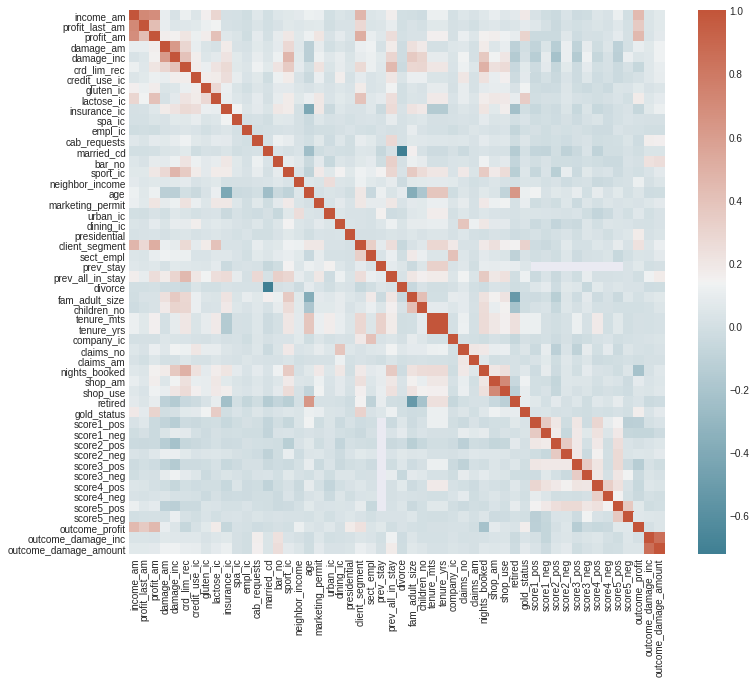

In [ ]:
plt.figure(figsize=(12,10))
cor = data_train.corr()
sns.heatmap(cor, annot=False, cmap=sns.diverging_palette(220, 20, as_cmap=True)
)
plt.show()

### Checking the variables we are trying to predict and dropping them from training set

In here, an auxiliary dataframe is created, that will contain variables we were trying to predict.

In [ ]:
predicted_features = ['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount']

print(data_train.columns)
data_feat = data_train.drop(predicted_features , axis=1)
print(data_feat.shape)

Index(['income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc',
       'crd_lim_rec', 'credit_use_ic', 'gluten_ic', 'lactose_ic',
       'insurance_ic', 'spa_ic', 'empl_ic', 'cab_requests', 'married_cd',
       'bar_no', 'sport_ic', 'neighbor_income', 'age', 'marketing_permit',
       'urban_ic', 'dining_ic', 'presidential', 'client_segment', 'sect_empl',
       'prev_stay', 'prev_all_in_stay', 'divorce', 'fam_adult_size',
       'children_no', 'tenure_mts', 'tenure_yrs', 'company_ic', 'claims_no',
       'claims_am', 'nights_booked', 'gender', 'shop_am', 'shop_use',
       'retired', 'gold_status', 'score1_pos', 'score1_neg', 'score2_pos',
       'score2_neg', 'score3_pos', 'score3_neg', 'score4_pos', 'score4_neg',
       'score5_pos', 'score5_neg', 'outcome_profit', 'outcome_damage_inc',
       'outcome_damage_amount'],
      dtype='object')
(4947, 50)


In [ ]:

data_target  = data_train[predicted_features].copy()
data_target["abs_value"] = data_target['outcome_profit'].sub(data_target['outcome_damage_amount'], fill_value=np.NAN)


client_labels = ["very bad","bad" ,"average", "good","very good"]
data_target["client_classes"] = pd.qcut(data_target["abs_value"], 5, labels = client_labels )
data_target['client_class'] = data_target['client_classes'].apply(lambda x:'Good' if x=='good' or x=="very good" else 'Bad').astype('category')

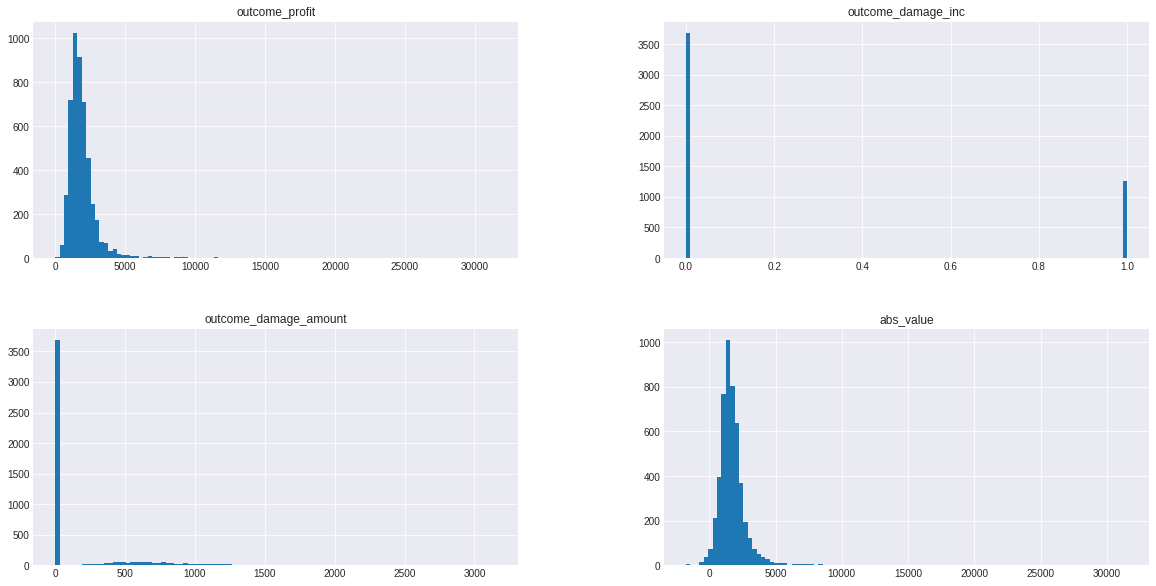

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

_ = data_target.hist(bins = 100)

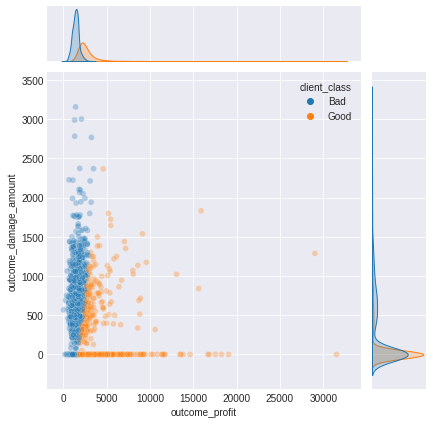

In [ ]:
plot =  sns.jointplot(
    data=data_target,
    x='outcome_profit',y= 'outcome_damage_amount',alpha=0.3, hue = 'client_class', 
    
)

plt.show()


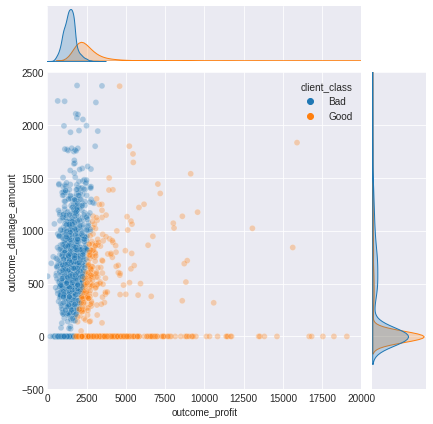

In [ ]:
plot =  sns.jointplot(
    data=data_target,
    x='outcome_profit',y= 'outcome_damage_amount',alpha=0.3, hue = 'client_class', 
    
)
plot.ax_marg_x.set_xlim(0,  20000)
plot.ax_marg_y.set_ylim(-500, 2500)
plot.ax_joint.plot([0,0], [2500,2500], 'b-', linewidth = 2)
plt.show()

### Preprocessing part

After this, the preprocessing will actually start. But first, it is important to understand that what is done in the training data set, has to also be done also in the score data set. For this, both data set will be fused, but the outcomes need to be dropped.

In [ ]:
data_feat_shape = data_feat.shape
score_shape = score.shape
print(score.shape)
print(data_feat.shape)

datafull = pd.concat([data_feat, score])


(496, 50)
(4947, 50)


Then categorical features were chosen. In the next part, the different values of each of them are counted. 

In [ ]:
print(datafull['client_segment'].value_counts())
print(datafull['sect_empl'].value_counts())
print(datafull['gender'].value_counts())
print(datafull['retired'].value_counts())
print(datafull['gold_status'].value_counts())
print(datafull['prev_stay'].value_counts())
print(datafull['divorce'].value_counts())
print(datafull['married_cd'].value_counts())

1.0    3712
2.0     925
0.0     352
3.0     329
4.0      87
5.0      38
Name: client_segment, dtype: int64
0.0    4820
1.0     468
6.0      78
2.0      45
4.0      29
3.0       3
Name: sect_empl, dtype: int64
M    2734
V    2709
Name: gender, dtype: int64
0.0    4456
1.0     987
Name: retired, dtype: int64
0.0    5241
1.0     202
Name: gold_status, dtype: int64
1.0    4848
0.0     595
Name: prev_stay, dtype: int64
0.0    4884
1.0     559
Name: divorce, dtype: int64
True     4460
False     983
Name: married_cd, dtype: int64


For the variables, a mode imputation was done instead of making a separate missing category. A disadvantage is that the most frequent value will be favored. But every technique, has its downfalls.

In [ ]:
# datafull['client_segment'] = pd.Categorical(datafull['client_segment'])
# datafull['sect_empl'] = pd.Categorical(datafull['sect_empl'])
# datafull['retired'] = pd.Categorical(datafull['retired'])
# datafull['gold_status'] = pd.Categorical(datafull['gold_status'])
# datafull['prev_stay'] = pd.Categorical(datafull['prev_stay'])
# datafull['divorce'] = pd.Categorical(datafull['divorce'])
categorical_columns = ['client_segment', "credit_use_ic", "gluten_ic", "lactose_ic","insurance_ic","marketing_permit", "presidential", "urban_ic", "prev_all_in_stay", "shop_use", 
             "company_ic", "dining_ic", "spa_ic","sport_ic","empl_ic",'sect_empl', "retired", "gold_status", "prev_stay", 'divorce', "gender"]
impute_mode = SimpleImputer (strategy='most_frequent')
for cols in categorical_columns:  
      datafull[cols] = impute_mode.fit_transform(datafull[[cols]])

The categorical features that had values different from 0 and 1, were dummified (separated in categories) 

In [ ]:
datafull['client_segment'] = pd.Categorical(datafull['client_segment'])
datafull['sect_empl'] = pd.Categorical(datafull['sect_empl'])
# The NaN categorie won't be necessary anymore, thanks to the mode imputing.
pd.get_dummies(datafull[['client_segment', 'sect_empl']], dummy_na=False).head()
print(datafull.shape)
datafull2 = pd.concat([datafull,pd.get_dummies(datafull[['gender','client_segment', 'sect_empl']], dummy_na=False)], axis=1)
print(datafull2.shape)
print(datafull2.head(1000))     

(5443, 50)
(5443, 64)
     income_am  profit_last_am  ...  sect_empl_4.0  sect_empl_6.0
0        227.0             0.0  ...              0              0
1        268.0            16.0  ...              0              0
2        283.0            23.0  ...              0              0
3        227.0             0.0  ...              0              0
4       4091.0          1028.0  ...              0              0
..         ...             ...  ...            ...            ...
995     1543.0            46.0  ...              0              0
996      847.0           260.0  ...              0              0
997      227.0             0.0  ...              0              0
998      227.0             0.0  ...              0              0
999      227.0             0.0  ...              0              0

[1000 rows x 64 columns]


After creating the dummies for the necessary variables, the original features and 1 dummy category was dropped in each of them. Also a new  feature, "profit per night" was created.

In [ ]:
datafull2.drop(['client_segment', 'sect_empl', 'gender', 'client_segment_5.0','sect_empl_6.0','gender_V'], axis=1, inplace=True)
datafull2.shape

datafull2['profitpernight'] = datafull2['profit_am'] / datafull2['nights_booked']

Now the data with over 25% missing values will be found. Most of it consist in the features related to scores. The solution dropped them, but we decided to try another option.

In [ ]:
(datafull2.isnull().mean())[datafull2.isnull().mean() > 0.25]

score1_pos    0.752526
score1_neg    0.733970
score2_pos    0.757487
score2_neg    0.737645
score3_pos    0.743340
score3_neg    0.722212
score4_pos    0.753445
score4_neg    0.733603
score5_pos    0.749403
score5_neg    0.697410
dtype: float64

Something important that was mentioned during class was that sometimes it is not worthy to use very complex methods like soft imputing to avoid dropping features with missing values. So we decided to try something simple: a mean imputing. The scores are quantitative, and of course, a downside of this is that it could bring us distortion.

In [ ]:
impute_quant = SimpleImputer (strategy='mean')
for cols in ['score1_pos', 'score1_neg', 'score2_pos', 'score2_neg', 'score3_pos',
       'score3_neg', 'score4_pos', 'score4_neg', 'score5_pos', 'score5_neg']:  # Missing data, Scores are quantitative
      datafull2[cols] = impute_quant.fit_transform(datafull2[[cols]])

After this, a mean imputation was done for the other missing values that could be present (here the binary data was already treated before). And at the end there was no more missing data.

In [ ]:
print(datafull2.isnull().sum().sum())
datafull2.fillna(datafull2.mean(), inplace=True)
print(datafull2.isnull().sum().sum())

987
0


In [ ]:
def return_categorical(datafull):
  df = datafull.copy()
  x = df.nunique()
  
  df_categorical = df[list(x[x<=2].index)].copy()
  categorical_features =list(df_categorical.columns.values)
  datafull[categorical_features] = datafull[categorical_features].astype('int')
  return categorical_features, datafull

categorical_features, datafull2 = return_categorical(datafull2)

In [ ]:
datafull2.isnull().sum()
datafull2

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,gender_M,client_segment_0.0,client_segment_1.0,client_segment_2.0,client_segment_3.0,client_segment_4.0,sect_empl_0.0,sect_empl_1.0,sect_empl_2.0,sect_empl_3.0,sect_empl_4.0,profitpernight
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0,0,0,0,1,0,3.0,1,2.0,1,28936.0,37.0,0,1,0,0,1,1,0,3.0,2.0,476.000000,40.000000,0,0.0,0.0,209.0,0.000000,0,0,0,0.467768,0.983340,0.498819,0.499142,0.494360,0.497319,0.838147,0.082288,0.501332,5.158644,1,0,1,0,0,0,0,1,0,0,0,15.315789
1,268.0,16.0,1682.0,0.0,0.0,750.0,0,0,0,1,1,0,7.0,1,3.0,0,16674.0,18.0,0,0,0,0,0,0,0,1.0,0.0,27.000000,2.000000,0,0.0,0.0,4.0,0.000000,0,0,0,0.501515,0.500278,0.498819,0.499142,0.494360,0.497319,0.499849,0.500775,0.501332,7.955259,1,0,1,0,0,0,1,0,0,0,0,420.500000
2,283.0,23.0,1673.0,0.0,0.0,750.0,0,0,0,1,0,0,1.0,1,4.0,0,32552.0,21.0,0,1,0,0,1,0,0,1.0,0.0,95.000000,8.000000,0,0.0,0.0,6.0,0.000000,0,0,0,0.501515,0.500278,0.232375,0.099529,0.494360,0.497319,0.499849,0.500775,0.101955,1.743020,1,0,1,0,0,0,1,0,0,0,0,278.833333
3,227.0,0.0,1685.0,0.0,0.0,0.0,0,0,0,0,0,0,6.0,1,8.0,1,32252.0,37.0,0,1,0,0,1,0,0,3.0,2.0,273.586112,22.818899,0,0.0,0.0,4.0,0.000000,0,0,0,0.501515,0.500278,0.498819,0.499142,0.494360,0.889793,0.499849,0.500775,0.501332,5.158644,0,0,1,0,0,0,1,0,0,0,0,421.250000
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0,0,1,0,1,0,4.0,0,2.0,1,29605.0,26.0,0,1,0,0,1,0,0,2.0,0.0,354.000000,30.000000,0,0.0,0.0,3.0,1454.210627,1,0,0,0.501515,0.500278,0.498819,0.499142,0.330503,0.766294,0.490486,0.542445,0.501332,5.158644,0,0,0,1,0,0,1,0,0,0,0,1141.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,820.0,216.0,7794.0,1103.0,3.0,9000.0,0,0,0,1,1,0,5.0,1,3.0,0,41379.0,40.0,1,1,0,0,1,0,0,1.0,1.0,242.000000,20.000000,0,0.0,0.0,39.0,0.000000,0,0,0,0.307239,0.660891,0.498819,0.499142,0.738333,0.914151,0.499849,0.500775,0.262224,8.060677,1,0,1,0,0,0,1,0,0,0,0,199.846154
492,6092.0,2100.0,3137.0,0.0,0.0,0.0,0,0,0,0,1,0,6.0,0,8.0,0,37460.0,44.0,1,1,0,0,1,0,1,2.0,0.0,431.000000,36.000000,0,0.0,0.0,2.0,4073.484264,1,0,0,0.501515,0.500278,0.419981,0.668320,0.494360,0.497319,0.499849,0.500775,0.501332,5.158644,0,0,0,1,0,0,1,0,0,0,0,1568.500000
493,2301.0,214.0,2516.0,0.0,0.0,11000.0,0,0,0,0,0,0,7.0,1,1.0,0,24007.0,38.0,1,1,0,0,1,1,0,2.0,0.0,374.000000,31.000000,0,0.0,0.0,17.0,2416.668965,1,0,0,0.837325,0.663044,0.697171,0.353229,0.494360,0.497319,0.499849,0.500775,0.501332,5.158644,1,0,1,0,0,0,0,1,0,0,0,148.000000
494,492.0,0.0,3716.0,713.0,2.0,5000.0,0,0,0,1,1,0,7.0,1,0.0,1,36542.0,47.0,0,1,0,0,1,0,0,3.0,2.0,289.000000,24.000000,0,0.0,0.0,45.0,0.000000,0,0,0,0.501515,0.500278,0.498819,0.499142,0.494360,0.497319,0.499849,0.500775,0.461598,4.757132,1,0,1,0,0,0,1,0,0,0,0,82.577778


### Scalling the dataset
**In** the next section, the features will be rescaled. We need to avoid scalling binary variables, Also we need to convert them to int.

In [ ]:
numerical_features = list(set(datafull2.columns) -  set(categorical_features))
 
datafull3 = datafull2.copy()
scaler = StandardScaler()
data = []
for cols in numerical_features:  
      datafull3[cols] = scaler.fit_transform(datafull2[[cols]])

Then, the score and the train datasets will be separated and the outcome features will be reinstated.

### Returning to the previous shape




In [ ]:

print(data_feat_shape[0] + score_shape[0])
print(data_feat_shape[0])


5443
4947


In [ ]:
def return_orginal_shape(df):
  data_train = df[0:data_feat_shape[0]]
  score = df[data_feat_shape[0]:data_feat_shape[0] + score_shape[0]]
  return data_train, score

data_train, score = return_orginal_shape(datafull3)
data_train = pd.concat([data_target[['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount']],data_train], axis=1)

#### Downloading the files 

In [ ]:
from google.colab import files
data_train.to_csv('data_train_scaled.csv') 
files.download('data_train_scaled.csv')

score.to_csv('score_scaled.csv') 
files.download('score_scaled.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Feature importance regression

This is an optional part. We are looking for relation (identifying variables that may be most relevant).

In [ ]:
from sklearn import feature_selection
from scipy import stats
from collections import defaultdict

def feature_importance_regression(features, target, n_neighbors=4, random_state=None):

    cont = features.select_dtypes(include=[np.floating])
    disc = features.select_dtypes(include=[np.integer, np.bool])

    cont_imp = pd.DataFrame(index=cont.columns)
    disc_imp = pd.DataFrame(index=disc.columns)

    # Continuous features
    if cont_imp.index.size > 0:

        # Pearson correlation
        pearson = np.array([stats.pearsonr(feature, target) for _, feature in cont.iteritems()])
        cont_imp['pearson_r'] = pearson[:, 0]
        cont_imp['pearson_r_p_value'] = pearson[:, 1]

        # Mutual information
        mut_inf = feature_selection.mutual_info_regression(cont, target, discrete_features=False,
                                                           n_neighbors=n_neighbors,
                                                           random_state=random_state)
        cont_imp['mutual_information'] = mut_inf

    # Discrete features
    if disc_imp.index.size > 0:

        # F-test
        f_tests = defaultdict(dict)

        for feature in disc.columns:
            groups = [target[idxs] for idxs in disc.groupby(feature).groups.values()]
            statistic, p_value = stats.f_oneway(*groups)
            f_tests[feature]['f_statistic'] = statistic
            f_tests[feature]['f_p_value'] = p_value

        f_tests_df = pd.DataFrame.from_dict(f_tests, orient='index')
        disc_imp['f_statistic'] = f_tests_df['f_statistic']
        disc_imp['f_p_value'] = f_tests_df['f_p_value']

        # Mutual information
        mut_inf = feature_selection.mutual_info_regression(disc, target, discrete_features=True,
                                                           n_neighbors=n_neighbors,
                                                           random_state=random_state)
        disc_imp['mutual_information'] = mut_inf

    return cont_imp, disc_imp 

#### Outcome profit

In [ ]:
data_preproc, score_preproc = return_orginal_shape(datafull2)


In [ ]:
#for count, item in enumerate(data_target):
#  cont_imp, disc_imp = feature_importance_regression(data_preproc, data_target[item].values, n_neighbors=3, random_state=None)
#  display(item)
#  display(cont_imp.sort_values(by=['pearson_r'], ascending = False).round(3))
#  display(disc_imp.sort_values(by=['f_statistic'], ascending = False).round(3))

# 2. Profit Model

### Splitting the data into test set

After the preprocessing, the data was split in train and test. The test size was decided to be 20%, so that more data was available for the training.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_train['outcome_profit'], test_size=0.2, random_state=48)

The model for profit will try 500 random hyperparameter combinations, each time using 5 Cross Validation folds, totalling 2500 fits. It takes a while to run (around 40 minutes).

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
learning_rate = [x for x in np.logspace(start = -3, stop = -0.01, num = 50)]
max_features = ['auto']
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [2, 5, 10, 30]
min_samples_leaf = [1, 2, 4, 10, 30]
subsample = [0.4, 0.6, 0.8, 1]
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'subsample': subsample}
gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=2, random_state=42, n_jobs = -1)
gbm_random.fit(X_train, y_train)
gbm_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


KeyboardInterrupt: ignored

In the next section the model is pickled. The reason is to not let all that time that the model took to run, to get wasted. It is a way to persist it.

In [ ]:
score.to_pickle(data_output_path / "score_v3.pkl")
data_train.to_pickle(data_output_path / "data_train_v3.pkl")
joblib.dump(gbm_random, 'random_search_gbm.pkl')

Then the output is examined.

In [ ]:
pd.DataFrame(gbm_random.cv_results_).head()

After this, the best hyperparameter combination is inspected. 

In [ ]:
pd.DataFrame(gbm_random.cv_results_).loc[pd.DataFrame(gbm_random.cv_results_)['mean_test_score'].idxmax()]

Finally, the best parameters are used to fit the model

In [ ]:
params = gbm_random.best_params_
gbm_profit = GradientBoostingRegressor(**params)
gbm_profit.fit(X_train, y_train)
# I got R2: 0.975 for the X_train and R2: 0.829 for the X_test
print('R2: %.3f' % gbm_profit.score(X_train, np.array(y_train).reshape(-1,1)))
print('R2: %.3f' % gbm_profit.score(X_test, np.array(y_test).reshape(-1,1))) #Here we are using the "holdout" set already

And in the last point, the potential clients are scored with the model, and this is saved.

In [ ]:
profit_preds = gbm_profit.predict(score)


In [ ]:
np.save(data_output_path / "profit_preds_v3.pkl", profit_preds)


Then a way to "whitebox" the model was tried. For it, the variables that mattered were identified using Variable importances based on impurity reduction.


In [ ]:
gbm_profit.feature_importances_.sum()
d = {'feature':X_train.columns, 'importance':gbm_profit.feature_importances_}
importances = pd.DataFrame(data=d)
importances.sort_values('importance', ascending=False,inplace=True)

plt.rcdefaults()
plt.rcParams['figure.figsize'] = (4, 3)
fig, ax = plt.subplots()
variables = importances.feature
y_pos = np.arange(len(variables))
scaled_importance = importances.importance
ax.barh(y_pos, scaled_importance, align='center', color='deepskyblue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()


This graphic is unorganized. All the variables are shown in the y axis, it is difficult to read them. So it were orgaized in the next section.

In [ ]:
importances2 = importances.copy()
importances2 = importances2.head(20)
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams['figure.figsize'] = (4, 3)
fig, ax = plt.subplots()
variables = importances2.feature
y_pos = np.arange(len(variables))
scaled_importance = importances2.importance
ax.barh(y_pos, scaled_importance, align='center', color='deepskyblue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
# And now we have a nice plot

After this, Permutation importance was used. As it can be seen, Feature importance and Permutation importance identify the same strongly predictive features for the model for Profit: Profit per night, Mean taxable income of neighborhood, Presidential suit previous use, and the amount spent in shop, but in different order (for permutation the Presidential suit use and the amount spent on shop come higher than the neighborhood income).

In [ ]:
imp = permutation_importance(gbm_profit, X_train, y_train,n_repeats=10,
                                random_state=42, n_jobs=2)



sorted_idx = imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(imp.importances[sorted_idx][48:59].T, vert=False, labels=X_train.columns[sorted_idx][48:59])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

#  Prediction of damage (binary)

## GradientBoostingClassifier

The next part of the work is to predict damage. So, next, we will check the amount of different cases in different groups. For this, Gradient Boosting was used. The reason of using Gradient Boosting is that it was that it is an algorithm that delivers good results using decision trees. This time it was fitted 300 times (CV was 3 in this ocasion, so it ran faster than the last model). The test part was also 20%.

In [ ]:
data_train.outcome_damage_inc.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1), 
                                                    data_train['outcome_damage_inc'], test_size=0.2, random_state=48)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
learning_rate = [x for x in np.logspace(start = -3, stop = -0.01, num = 50)]
max_features = ['auto']
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [2, 5, 10, 30]
min_samples_leaf = [1, 2, 4, 10, 30]
subsample = [0.4, 0.6, 0.8, 1]
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'subsample': subsample}
gbm = GradientBoostingClassifier()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
gbm_random.fit(X_train, y_train)
gbm_random.best_params_

NameError: ignored

In [ ]:
params = gbm_random.best_params_
gbm_damagebin = GradientBoostingClassifier(**params)
gbm_damagebin.fit(X_train, y_train)
print('Train accuracy: %.3f' % gbm_damagebin.score(X_train, y_train))
print('Test accuracy: %.3f' % gbm_damagebin.score(X_test, y_test))

## Option 2: Hist gradient boosting classifier
Now let's see if we have better results using the Histogram Gradiënt Boosting Classifier.

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1), 
                                                    data_train['outcome_damage_inc'], test_size=0.2, random_state=48)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
learning_rate = [x for x in np.logspace(start = -3, stop = -0.01, num = 50)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_leaf = [1, 2, 4, 10, 30]
random_grid = {'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}
hgbm = HistGradientBoostingClassifier()
hgbm_random = RandomizedSearchCV(estimator = hgbm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
hgbm_random.fit(X_train, y_train)
hgbm_random.best_params_

In [ ]:
params = hgbm_random.best_params_
hgbm_damagebin = GradientBoostingClassifier(**params)


print('Train accuracy: %.3f' % hgbm_damagebin.score(X_train, y_train))
print('Test accuracy: %.3f' % hgbm_damagebin.score(X_test, y_test))

In [ ]:
damagebin_preds = hgbm_damagebin.predict_proba(score)
np.save(data_output_path / "damagebin_preds_v3.pkl", damagebin_preds)


## Simple logistic regression with features removes  as basis model

In [ ]:
score = pd.read_csv('https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/processed/score_scaled.csv', index_col=[0])
data_train = pd.read_csv('https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/processed/data_train_scaled.csv',index_col=[0])

display(data_train.dtypes)
display(data_train)


outcome_profit           float64
outcome_damage_inc         int64
outcome_damage_amount    float64
income_am                float64
profit_last_am           float64
                          ...   
sect_empl_1.0              int64
sect_empl_2.0              int64
sect_empl_3.0              int64
sect_empl_4.0              int64
profitpernight           float64
Length: 62, dtype: object

,outcome_profit,outcome_damage_inc,outcome_damage_amount,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,gender_M,client_segment_0.0,client_segment_1.0,client_segment_2.0,client_segment_3.0,client_segment_4.0,sect_empl_0.0,sect_empl_1.0,sect_empl_2.0,sect_empl_3.0,sect_empl_4.0,profitpernight
0,1791.66,0,0.00,-0.252204,-0.235716,-0.080882,1.301738,6.332496,2.566910,0,0,0,0,1,0,-0.983939,1,-0.727748,1,-0.574737,-0.484916,0,1,0,0,1,1,0,1.288844,1.935413,1.374007,1.398465e+00,0,-0.30462,-0.066999,4.777023,-0.301437,0,0,0,-0.235107,3.240857e+00,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,2.360180e+00,-2.812824,0.000000,-5.155797e-16,1,0,1,0,0,0,0,1,0,0,0,-0.446616
1,1672.78,1,829.66,-0.247235,-0.230252,-0.347972,-0.256938,-0.398615,-0.561289,0,0,0,1,1,0,0.312238,1,-0.527791,0,-2.413230,-1.658641,0,0,0,0,0,0,0,-1.199249,-0.460687,-1.673853,-1.694566e+00,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,1.623410e+00,1,0,1,0,0,0,1,0,0,0,0,-0.115700
2,1001.40,0,0.00,-0.245417,-0.227862,-0.349554,-0.256938,-0.398615,-0.561289,0,0,0,1,0,0,-1.632027,1,-0.327835,0,-0.032574,-1.473316,0,1,0,0,1,0,0,-1.199249,-0.460687,-1.212262,-1.206192e+00,0,-0.30462,-0.066999,-0.609490,-0.301437,0,0,0,0.000000,7.448483e-16,-1.884848e+00,-2.699639e+00,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,-2.739122,-1.982739e+00,1,0,1,0,0,0,1,0,0,0,0,-0.231400
3,1785.59,0,0.00,-0.252204,-0.235716,-0.347444,-0.256938,-0.398615,-0.725932,0,0,0,0,0,0,-0.011806,1,0.471989,1,-0.077555,-0.484916,0,1,0,0,1,0,0,1.288844,1.935413,0.000000,-2.891751e-16,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,2.584963e+00,-3.872809e-16,0.000000,0.000000,-5.155797e-16,0,0,1,0,0,0,1,0,0,0,0,-0.115087
4,3140.74,0,0.00,0.216113,0.115296,-0.041496,1.120946,1.845089,2.347387,0,0,1,0,1,0,-0.659895,0,-0.727748,1,-0.474431,-1.164441,0,1,0,0,1,0,0,0.044798,-0.460687,0.545858,5.845096e-01,0,-0.30462,-0.066999,-0.689094,0.782642,1,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-1.117528e+00,1.771561e+00,-6.532348e-02,0.280081,0.000000,-5.155797e-16,0,0,0,1,0,0,1,0,0,0,0,0.473282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,2172.82,0,0.00,-0.208936,-0.217960,-0.332674,-0.256938,-0.398615,-0.725932,0,0,0,0,1,0,1.284370,1,-0.327835,0,-0.206348,-1.473316,1,1,0,0,1,0,0,0.044798,-0.460687,-0.533451,-5.550280e-01,0,-0.30462,-0.066999,-0.715628,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,1.713795e+00,-1.326337e+00,2.309840e+00,-2.886235,-1.290270,-8.238897e-01,0,0,1,0,0,0,1,0,0,0,0,0.263252
4943,1057.83,0,0.00,-0.252204,-0.235716,-0.358873,-0.256938,-0.398615,-0.725932,0,0,0,0,0,0,0.312238,1,-0.127879,0,-0.965615,1.491883,0,0,0,0,0,1,0,-1.199249,-0.460687,0.518706,5.031141e-01,0,-0.30462,-0.066999,-0.264541,-0.301437,0,1,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,-5.155797e-16,1,0,1,0,0,0,1,0,0,0,0,-0.389490
4944,188.77,0,0.00,-0.250750,-0.234008,-0.280100,-0.256938,-0.398615,-0.177125,0,0,0,1,0,0,-1.632027,0,0.471989,1,-0.718823,0.997684,1,0,0,0,1,0,1,-1.199249,-0.460687,-0.689578,-7.178191e-01,0,-0.30462,-0.066999,0.982583,-0.301437,0,1,0,0.000000,7.448483e-16,-5

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_train['outcome_damage_inc'], test_size=0.2,  random_state=48)

In [ ]:
X_train

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,gender_M,client_segment_0.0,client_segment_1.0,client_segment_2.0,client_segment_3.0,client_segment_4.0,sect_empl_0.0,sect_empl_1.0,sect_empl_2.0,sect_empl_3.0,sect_empl_4.0,profitpernight
941,0.356098,0.433870,-0.210295,-0.256938,-0.398615,-0.177125,0,0,0,0,0,0,0.312238,0,0.671945,0,0.272392,0.071059,1,1,0,0,1,0,0,-1.199249,-0.460687,0.708773,7.473007e-01,0,-0.30462,-0.066999,0.106943,-0.301437,0,1,0,0.000000,7.448483e-16,-2.789862e+00,-3.078042e+00,2.113873e+00,3.051243e+00,-3.872809e-16,0.000000,0.0,-5.155797e-16,0,0,0,1,0,0,1,0,0,0,0,-0.398119
97,-0.250992,-0.234350,-0.353071,-0.256938,-0.398615,-0.561289,0,0,0,1,1,0,-1.632027,1,0.272033,0,-0.715975,-1.596866,0,0,0,0,1,0,0,-1.199249,-0.460687,-0.642061,-6.364236e-01,0,-0.30462,-0.066999,-0.264541,-0.301437,0,0,0,0.000000,7.448483e-16,-1.198630e+00,-3.381568e-01,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.0,-5.155797e-16,0,0,1,0,0,0,1,0,0,0,0,-0.388071
224,-0.251962,-0.235716,-0.358697,-0.256938,-0.398615,-0.725932,0,0,0,0,0,0,0.960326,1,0.671945,0,6.218635,-1.782191,1,1,0,0,0,0,0,0.044798,1.935413,-1.653489,-1.613170e+00,0,-0.30462,-0.066999,1.141790,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.0,-5.155797e-16,1,0,1,0,0,0,1,0,0,0,0,-0.440738
4374,0.005225,-0.002504,-0.200097,-0.256938,-0.398615,-0.725932,0,0,0,0,1,0,-1.632027,1,0.072077,0,-0.088500,0.997684,0,1,0,0,1,0,0,-1.199249,-0.460687,-0.160105,-1.480503e-01,0,-0.30462,-0.066999,-0.689094,-0.301437,0,0,0,0.744371,2.575828e+00,2.837966e+00,2.330713e+00,-4.409264e-01,-2.281643e+00,-3.872809e-16,0.000000,0.0,-5.155797e-16,0,0,1,0,0,0,1,0,0,0,0,0.227725
2373,-0.202512,0.075176,-0.323531,-0.256938,-0.398615,-0.725932,0,0,0,1,0,0,0.636282,0,1.871682,1,0.232959,-0.114266,1,1,0,0,1,0,1,0.044798,-0.460687,0.000000,-2.891751e-16,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,1.933051e+00,-3.785955e-16,-5.347330e-01,-3.872809e-16,1.833937,0.0,-5.155797e-16,1,0,1,0,0,0,1,0,0,0,0,-0.087319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,-0.246386,-0.235716,-0.080531,0.862922,0.723237,-0.725932,0,0,0,0,0,0,-1.632027,1,0.072077,0,0.179882,0.071059,0,1,0,0,1,0,0,0.044798,-0.460687,-1.850344,-1.857357e+00,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,2.612950,2.099223e+00,-1.665476e+00,-1.105929e+00,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.0,-5.155797e-16,1,1,0,0,0,0,1,0,0,0,0,0.194853
966,-0.252083,-0.235716,-0.357994,-0.256938,-0.398615,-0.067363,0,0,0,1,1,0,0.636282,0,-0.527791,0,-0.509665,-0.917341,1,1,0,0,0,0,0,1.288844,-0.460687,-1.741734,-1.775961e+00,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.0,-5.155797e-16,1,0,1,0,0,0,0,1,0,0,0,-0.127338
2395,-0.243114,0.209025,-0.185678,-0.256938,1.845089,2.018103,0,0,0,1,1,0,0.960326,1,2.471550,1,0.703303,-0.176041,1,1,0,0,1,1,0,1.288844,3.133462,0.294698,2.589274e-01,0,-0.30462,-0.066999,0.902979,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.0,-5.155797e-16,1,0,1,0,0,0,1,0,0,0,0,-0.425355
1361,-0.245053,-0.235716,-0.226296,-0.256938,-0.398615,-0.725932,0,0,0,0,0,0,1.284370,1,0.471989,1,-0.1

In [ ]:
y_train.values

array([0, 0, 0, ..., 1, 0, 0])

Simple criterion for inclusion -  pvalue smaller  than 0.05, mutual information higher than 0.005

In [ ]:
cont_imp, disc_imp = feature_importance_regression(X_train.reset_index(drop=True), y_train.values, n_neighbors=3, random_state=None)
display(item)
display(cont_imp.sort_values(by=['pearson_r'], ascending = False).round(3))
display(disc_imp.sort_values(by=['f_statistic'], ascending = False).round(3))




'client_classes'

,pearson_r,pearson_r_p_value,mutual_information
bar_no,0.231,0.000,0.041
cab_requests,0.167,0.000,0.018
damage_am,0.057,0.000,0.005
damage_inc,0.051,0.001,0.000
crd_lim_rec,0.049,0.002,0.000
score5_neg,0.041,0.010,0.010
fam_adult_size,0.033,0.039,0.000
profit_am,0.025,0.111,0.000
score2_neg,0.023,0.142,0.000
shop_am,0.023,0.143,0.008


,f_statistic,f_p_value,mutual_information
prev_all_in_stay,65.162,0.000,0.004
gender_M,51.028,0.000,0.016
insurance_ic,18.988,0.000,0.000
lactose_ic,16.143,0.000,0.000
client_segment_4.0,12.702,0.000,0.000
sect_empl_2.0,10.317,0.001,0.003
marketing_permit,9.574,0.002,0.007
credit_use_ic,7.083,0.008,0.000
retired,4.404,0.036,0.000
shop_use,3.892,0.049,0.000


In [ ]:

display(cont_imp[cont_imp['pearson_r_p_value'] <0.05].round(3))
display(list(cont_imp[cont_imp['pearson_r_p_value'] <0.05].index))
display(disc_imp[disc_imp['f_p_value'] <0.05].round(3))
display(cont_imp[cont_imp['mutual_information'] >0.005].round(3))
display(disc_imp[disc_imp['mutual_information'] >0.005].round(3))

,pearson_r,pearson_r_p_value,mutual_information
damage_am,0.057,0.000,0.005
damage_inc,0.051,0.001,0.000
crd_lim_rec,0.049,0.002,0.000
cab_requests,0.167,0.000,0.018
bar_no,0.231,0.000,0.041
fam_adult_size,0.033,0.039,0.000
score1_neg,-0.051,0.001,0.000
score5_neg,0.041,0.010,0.010


['damage_am',
 'damage_inc',
 'crd_lim_rec',
 'cab_requests',
 'bar_no',
 'fam_adult_size',
 'score1_neg',
 'score5_neg']

,f_statistic,f_p_value,mutual_information
credit_use_ic,7.083,0.008,0.000
lactose_ic,16.143,0.000,0.000
insurance_ic,18.988,0.000,0.000
marketing_permit,9.574,0.002,0.007
prev_all_in_stay,65.162,0.000,0.004
shop_use,3.892,0.049,0.000
retired,4.404,0.036,0.000
gender_M,51.028,0.000,0.016
client_segment_4.0,12.702,0.000,0.000
sect_empl_2.0,10.317,0.001,0.003


,pearson_r,pearson_r_p_value,mutual_information
damage_am,0.057,0.000,0.005
cab_requests,0.167,0.000,0.018
bar_no,0.231,0.000,0.041
shop_am,0.023,0.143,0.008
score1_pos,-0.004,0.779,0.006
score4_neg,0.001,0.968,0.010
score5_pos,0.003,0.850,0.012
score5_neg,0.041,0.010,0.010


,f_statistic,f_p_value,mutual_information
married_cd,3.344,0.068,0.006
marketing_permit,9.574,0.002,0.007
gender_M,51.028,0.000,0.016
client_segment_0.0,2.075,0.150,0.006


In [ ]:
lista = [] 
cont_imp, disc_imp = feature_importance_regression(X_train.reset_index(drop=True), y_train.values, n_neighbors=3, random_state=None)

lista.extend(list(cont_imp[cont_imp['pearson_r_p_value'] <0.05].index))
lista.extend(list(disc_imp[disc_imp['f_p_value'] <0.05].index))
lista.extend(list(disc_imp[disc_imp['mutual_information'] > 0.005].index))
lista.extend(list(cont_imp[cont_imp['mutual_information'] > 0.005].index))
final_list = list(set(lista))
display(final_list)
len(final_list)

['score5_neg',
 'credit_use_ic',
 'client_segment_0.0',
 'client_segment_4.0',
 'score1_pos',
 'score5_pos',
 'score4_neg',
 'lactose_ic',
 'insurance_ic',
 'sect_empl_2.0',
 'shop_use',
 'gender_M',
 'married_cd',
 'bar_no',
 'marketing_permit',
 'cab_requests',
 'damage_inc',
 'prev_all_in_stay',
 'fam_adult_size',
 'shop_am',
 'damage_am',
 'crd_lim_rec',
 'retired',
 'score1_neg']

24

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train[final_list ], y_train)
print('Train accuracy: {:.2f}'.format(logreg.score(X_train[final_list], y_train)))
print('Test accuracy: {:.2f}'.format(logreg.score(X_test[final_list], y_test)))
logreg.predict_proba(X_test[final_list])

Train accuracy: 0.76
Test accuracy: 0.74


array([[0.94328094, 0.05671906],
       [0.74032712, 0.25967288],
       [0.76917121, 0.23082879],
       ...,
       [0.8819722 , 0.1180278 ],
       [0.41177519, 0.58822481],
       [0.7391513 , 0.2608487 ]])

In [ ]:
y_pred = logreg.predict(X_test[final_list])


Train accuracy: 0.76
Test accuracy: 0.74


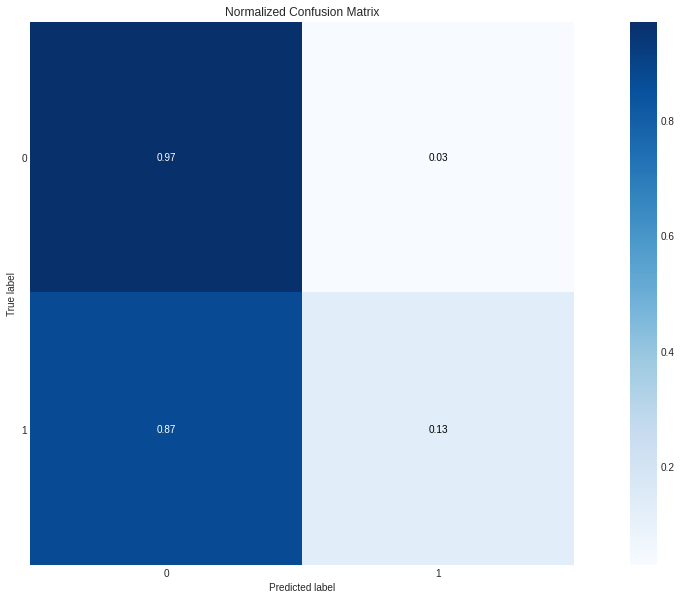

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = ['no damage', 'damage']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   no damage       0.75      0.97      0.85       720
      damage       0.64      0.13      0.22       270

    accuracy                           0.74       990
   macro avg       0.70      0.55      0.53       990
weighted avg       0.72      0.74      0.68       990



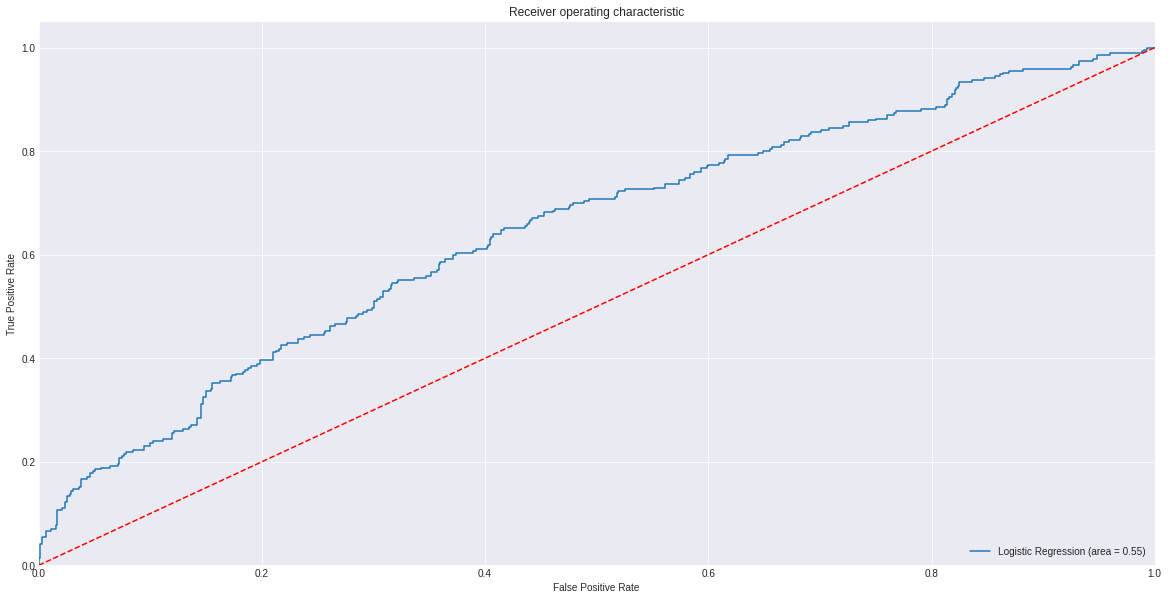

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test[final_list]))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test[final_list])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

We see that this is not good model. The main problem may be unbalanced data. ROC curve is not so informative for unbalanced data. We try here precision recall curve

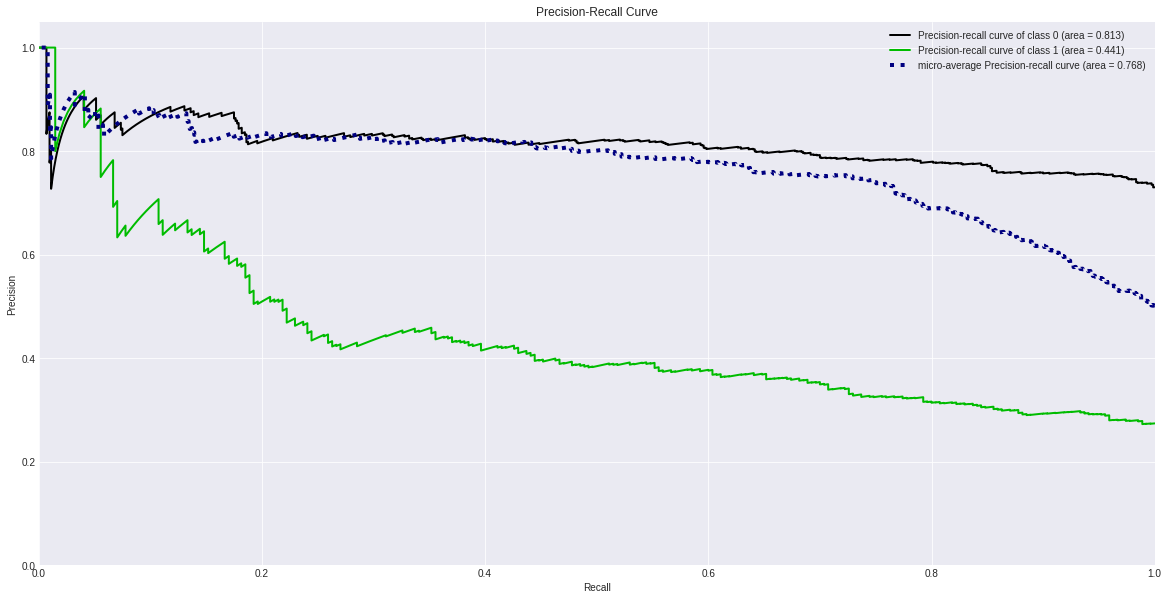

In [ ]:
import scikitplot as skplt
y_pred_prob = logreg.predict_proba(X_test[final_list])

skplt.metrics.plot_precision_recall(y_test, y_pred_prob)

## Ridge Regression and various ways for mitigating inbalanced populations

In [ ]:
!pip install  imbalanced-learn==0.8.0

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
score = pd.read_csv('https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/processed/score_scaled.csv', index_col=[0])
data_train = pd.read_csv('https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/processed/data_train_scaled.csv',index_col=[0])

display(data_train.dtypes)
display(data_train)

outcome_profit           float64
outcome_damage_inc         int64
outcome_damage_amount    float64
income_am                float64
profit_last_am           float64
                          ...   
sect_empl_1.0              int64
sect_empl_2.0              int64
sect_empl_3.0              int64
sect_empl_4.0              int64
profitpernight           float64
Length: 62, dtype: object

,outcome_profit,outcome_damage_inc,outcome_damage_amount,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,gender_M,client_segment_0.0,client_segment_1.0,client_segment_2.0,client_segment_3.0,client_segment_4.0,sect_empl_0.0,sect_empl_1.0,sect_empl_2.0,sect_empl_3.0,sect_empl_4.0,profitpernight
0,1791.66,0,0.00,-0.252204,-0.235716,-0.080882,1.301738,6.332496,2.566910,0,0,0,0,1,0,-0.983939,1,-0.727748,1,-0.574737,-0.484916,0,1,0,0,1,1,0,1.288844,1.935413,1.374007,1.398465e+00,0,-0.30462,-0.066999,4.777023,-0.301437,0,0,0,-0.235107,3.240857e+00,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,2.360180e+00,-2.812824,0.000000,-5.155797e-16,1,0,1,0,0,0,0,1,0,0,0,-0.446616
1,1672.78,1,829.66,-0.247235,-0.230252,-0.347972,-0.256938,-0.398615,-0.561289,0,0,0,1,1,0,0.312238,1,-0.527791,0,-2.413230,-1.658641,0,0,0,0,0,0,0,-1.199249,-0.460687,-1.673853,-1.694566e+00,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,1.623410e+00,1,0,1,0,0,0,1,0,0,0,0,-0.115700
2,1001.40,0,0.00,-0.245417,-0.227862,-0.349554,-0.256938,-0.398615,-0.561289,0,0,0,1,0,0,-1.632027,1,-0.327835,0,-0.032574,-1.473316,0,1,0,0,1,0,0,-1.199249,-0.460687,-1.212262,-1.206192e+00,0,-0.30462,-0.066999,-0.609490,-0.301437,0,0,0,0.000000,7.448483e-16,-1.884848e+00,-2.699639e+00,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,-2.739122,-1.982739e+00,1,0,1,0,0,0,1,0,0,0,0,-0.231400
3,1785.59,0,0.00,-0.252204,-0.235716,-0.347444,-0.256938,-0.398615,-0.725932,0,0,0,0,0,0,-0.011806,1,0.471989,1,-0.077555,-0.484916,0,1,0,0,1,0,0,1.288844,1.935413,0.000000,-2.891751e-16,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,2.584963e+00,-3.872809e-16,0.000000,0.000000,-5.155797e-16,0,0,1,0,0,0,1,0,0,0,0,-0.115087
4,3140.74,0,0.00,0.216113,0.115296,-0.041496,1.120946,1.845089,2.347387,0,0,1,0,1,0,-0.659895,0,-0.727748,1,-0.474431,-1.164441,0,1,0,0,1,0,0,0.044798,-0.460687,0.545858,5.845096e-01,0,-0.30462,-0.066999,-0.689094,0.782642,1,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-1.117528e+00,1.771561e+00,-6.532348e-02,0.280081,0.000000,-5.155797e-16,0,0,0,1,0,0,1,0,0,0,0,0.473282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,2172.82,0,0.00,-0.208936,-0.217960,-0.332674,-0.256938,-0.398615,-0.725932,0,0,0,0,1,0,1.284370,1,-0.327835,0,-0.206348,-1.473316,1,1,0,0,1,0,0,0.044798,-0.460687,-0.533451,-5.550280e-01,0,-0.30462,-0.066999,-0.715628,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,1.713795e+00,-1.326337e+00,2.309840e+00,-2.886235,-1.290270,-8.238897e-01,0,0,1,0,0,0,1,0,0,0,0,0.263252
4943,1057.83,0,0.00,-0.252204,-0.235716,-0.358873,-0.256938,-0.398615,-0.725932,0,0,0,0,0,0,0.312238,1,-0.127879,0,-0.965615,1.491883,0,0,0,0,0,1,0,-1.199249,-0.460687,0.518706,5.031141e-01,0,-0.30462,-0.066999,-0.264541,-0.301437,0,1,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,-5.155797e-16,1,0,1,0,0,0,1,0,0,0,0,-0.389490
4944,188.77,0,0.00,-0.250750,-0.234008,-0.280100,-0.256938,-0.398615,-0.177125,0,0,0,1,0,0,-1.632027,0,0.471989,1,-0.718823,0.997684,1,0,0,0,1,0,1,-1.199249,-0.460687,-0.689578,-7.178191e-01,0,-0.30462,-0.066999,0.982583,-0.301437,0,1,0,0.000000,7.448483e-16,-5

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_train['outcome_damage_inc'], test_size=0.2,  random_state=48)
lista = [] 
cont_imp, disc_imp = feature_importance_regression(X_train.reset_index(drop=True), y_train.values, n_neighbors=3, random_state=None)

lista.extend(list(cont_imp[cont_imp['pearson_r_p_value'] <0.05].index))
lista.extend(list(disc_imp[disc_imp['f_p_value'] <0.05].index))
lista.extend(list(disc_imp[disc_imp['mutual_information'] > 0.005].index))
lista.extend(list(cont_imp[cont_imp['mutual_information'] > 0.005].index))
final_list = list(set(lista))
display(final_list)
len(final_list)

['damage_inc',
 'score4_neg',
 'fam_adult_size',
 'score3_neg',
 'prev_all_in_stay',
 'profitpernight',
 'score4_pos',
 'shop_use',
 'cab_requests',
 'marketing_permit',
 'married_cd',
 'sect_empl_2.0',
 'lactose_ic',
 'crd_lim_rec',
 'score5_neg',
 'score2_neg',
 'client_segment_4.0',
 'damage_am',
 'gender_M',
 'credit_use_ic',
 'insurance_ic',
 'score2_pos',
 'score1_neg',
 'retired',
 'bar_no',
 'children_no',
 'client_segment_1.0']

27

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import RidgeClassifier
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import RepeatedStratifiedKFold
 
def f2_measure(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model_ori):
  def f2_measure(y_true, y_pred):
	  return fbeta_score(y_true, y_pred, beta=2)
 
  cv_ori=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  #Evaluate model
  scoring=['accuracy','precision_macro','recall_macro']
  scores_ori = cross_validate(model_ori, X, y, scoring=scoring, cv=cv_ori, n_jobs=-1)

  # summarize performance
  print('Mean Accuracy: %.4f' % np.mean(scores_ori['test_accuracy']))
  print('Mean Precision: %.4f' % np.mean(scores_ori['test_precision_macro']))
  print('Mean Recall: %.4f' % np.mean(scores_ori['test_recall_macro']))

def evalute_train_test(model_ori, final_list):
  print("Results for train")
  evaluate_model(X_train[final_list ], y_train, model_ori)
  print("Results for test")
  evaluate_model(X_test[final_list], y_test, model_ori)



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train[final_list ], y_train)

evalute_train_test(logreg, final_list)

Results for train
Mean Accuracy: 0.7586
Mean Precision: 0.6796
Mean Recall: 0.5491
Results for test
Mean Accuracy: 0.7414
Mean Precision: 0.6714
Mean Recall: 0.5576


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
ridge = RidgeClassifier()
ridge.fit(X_train[final_list], y_train)

evalute_train_test(ridge, final_list)

Results for train
Mean Accuracy: 0.7571
Mean Precision: 0.6890
Mean Recall: 0.5354
Results for test
Mean Accuracy: 0.7394
Mean Precision: 0.6685
Mean Recall: 0.5469


In [ ]:
model = LogisticRegression()
# define the data sampling
sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))
pipeline = Pipeline(steps=[ ('over', RandomOverSampler()), ('m',model)])
# evaluate the model and store results
evalute_train_test(pipeline,final_list)

Results for train
Mean Accuracy: 0.6626
Mean Precision: 0.6165
Mean Recall: 0.6474
Results for test
Mean Accuracy: 0.6104
Mean Precision: 0.5718
Mean Recall: 0.5860


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
# define the data sampling
sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))
pipeline = Pipeline(steps=[ ('over', RandomOverSampler()), ('m',model)])
# evaluate the model and store results
evalute_train_test(pipeline, final_list)

Results for train
Mean Accuracy: 0.6609
Mean Precision: 0.5523
Mean Recall: 0.5532
Results for test
Mean Accuracy: 0.6343
Mean Precision: 0.5422
Mean Recall: 0.5430


In [ ]:
model = LogisticRegression()

from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
pipeline = Pipeline(steps=[ ('under', undersample), ('m',model)])
# evaluate the model and store results
evalute_train_test(pipeline, final_list)

Results for train
Mean Accuracy: 0.6538
Mean Precision: 0.6113
Mean Recall: 0.6421
Results for test
Mean Accuracy: 0.5993
Mean Precision: 0.5689
Mean Recall: 0.5837


# Last shot with XDboost


In [ ]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(X_train[final_list], y_train)
xg.fit(X_train[final_list], y_train)

evalute_train_test(xg, final_list)

Results for train
Mean Accuracy: 0.7576
Mean Precision: 0.6707
Mean Recall: 0.5526
Results for test
Mean Accuracy: 0.7286
Mean Precision: 0.6408
Mean Recall: 0.5461


The undersampling and oversampling methods doesnt do any good. The best model so far is logistic regression.

#### SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_train['outcome_damage_inc'], test_size=0.2,  random_state=48)

X_train= X_train[final_list]
X_test = X_test[final_list]


In [ ]:
from sklearn import svm


from sklearn.model_selection import RandomizedSearchCV
C = [x for x in np.logspace(start = -3, stop = 1, num = 30)]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [1,2,3,4,5]
gamma = ['auto', 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,0.5, 0.7,0.9]
random_grid = {'C': C,
               'kernel': kernel,
               'degree': degree,
               'gamma': gamma}
svc = svm.SVC()
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
svc_random.fit(X_train, y_train)

print(svc_random.best_params_)
params = svc_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'kernel': 'poly', 'gamma': 0.3, 'degree': 2, 'C': 0.03290344562312668}


In [ ]:
from sklearn import preprocessing
X_train= X_train[final_list]
X_test = X_test[final_list]
lab_enc= preprocessing.LabelEncoder()
y_train = lab_enc.fit_transform(y_train)
y_test = lab_enc.fit_transform(y_test)

In [ ]:
svc_randomBest = svm.SVC(**params)
svc_randomBest.fit(X_train, y_train)
print('Train accuracy: %.3f' % svc_randomBest.score(X_train, y_train))
print('Test accuracy: %.3f' % svc_randomBest.score(X_test, y_test))


Train accuracy: 0.765
Test accuracy: 0.736


In [ ]:
from sklearn.metrics import classification_report
target_names = ['not expensive', 'expensive']
print(classification_report(y_test, svc_randomBest.predict(X_test), target_names=target_names))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from scipy import stats
from collections import defaultdict

# Import All the required packages from sklearn
import numpy as np
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
score = pd.read_csv('https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/processed/score_scaled.csv', index_col=[0])
data_train = pd.read_csv('https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/processed/data_train_scaled.csv',index_col=[0])



list_binary_predictors = get_meaningful_variables(data_train)
data_binary = data_train[list_binary_predictors]
X_fit, X_eval, y_fit, y_test= model_selection.train_test_split( data_binary , data_train['outcome_damage_inc'], test_size=0.30, random_state=48 )


seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_fit, y_fit,cv=kfold)
for i in range(len(results)):
    print("Model: "+str(i)+" Accuracy is: "+str(results[i]))
print("Mean Accuracy is: "+str(results.mean()))
#data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount']
model.fit(X_fit, y_fit)
pred_label = model.predict(X_eval)
nnz = np.shape(y_test)[0] - np.count_nonzero(pred_label - y_test)
acc = 100*nnz/np.shape(y_test)[0]
print('accuracy is: '+str(acc))

# Prediction of damage (amount)

Because the prediction of the binary damage outcome was quite bad, then we will try to predict amount of the damage ignoring  the binary outcome, Again I will start friom filtering the appropriate variables.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_train['outcome_damage_amount'], test_size=0.2,  random_state=48)

In [ ]:
cont_imp, disc_imp = feature_importance_regression(X_train.reset_index(drop=True), y_train.values, n_neighbors=3, random_state=None)
display(cont_imp.sort_values(by=['pearson_r'], ascending = False).round(3))
display(disc_imp.sort_values(by=['f_statistic'], ascending = False).round(3))



,pearson_r,pearson_r_p_value,mutual_information
bar_no,0.247,0.000,0.034
cab_requests,0.163,0.000,0.018
damage_inc,0.127,0.000,0.006
damage_am,0.126,0.000,0.007
crd_lim_rec,0.102,0.000,0.006
profit_am,0.064,0.000,0.007
fam_adult_size,0.054,0.001,0.014
shop_am,0.040,0.012,0.009
children_no,0.039,0.013,0.000
income_am,0.039,0.015,0.007


,f_statistic,f_p_value,mutual_information
prev_all_in_stay,120.213,0.000,0.012
insurance_ic,48.010,0.000,0.008
gender_M,40.792,0.000,0.000
client_segment_4.0,36.308,0.000,0.002
lactose_ic,30.976,0.000,0.011
marketing_permit,24.444,0.000,0.001
credit_use_ic,17.553,0.000,0.008
gold_status,17.362,0.000,0.008
client_segment_1.0,13.341,0.000,0.000
sport_ic,11.679,0.001,0.002


In [ ]:
display(cont_imp[cont_imp['pearson_r_p_value'] <0.05].round(3))
display(list(cont_imp[cont_imp['pearson_r_p_value'] <0.05].index))
display(disc_imp[disc_imp['f_p_value'] <0.05].round(3))
display(cont_imp[cont_imp['mutual_information'] >0.005].round(3))
display(disc_imp[disc_imp['mutual_information'] >0.005].round(3))

,pearson_r,pearson_r_p_value,mutual_information
income_am,0.039,0.015,0.013
profit_last_am,0.032,0.041,0.000
profit_am,0.064,0.000,0.011
damage_am,0.126,0.000,0.016
damage_inc,0.127,0.000,0.015
crd_lim_rec,0.102,0.000,0.000
cab_requests,0.163,0.000,0.040
bar_no,0.247,0.000,0.031
neighbor_income,0.035,0.029,0.000
fam_adult_size,0.054,0.001,0.011


['income_am',
 'profit_last_am',
 'profit_am',
 'damage_am',
 'damage_inc',
 'crd_lim_rec',
 'cab_requests',
 'bar_no',
 'neighbor_income',
 'fam_adult_size',
 'children_no',
 'shop_am',
 'score2_neg',
 'score5_neg']

,f_statistic,f_p_value,mutual_information
credit_use_ic,17.553,0.000,0.005
gluten_ic,5.788,0.016,0.000
lactose_ic,30.976,0.000,0.007
insurance_ic,48.010,0.000,0.008
sport_ic,11.679,0.001,0.002
marketing_permit,24.444,0.000,0.008
urban_ic,4.736,0.030,0.000
presidential,5.599,0.018,0.000
prev_all_in_stay,120.213,0.000,0.010
company_ic,7.318,0.007,0.000


,pearson_r,pearson_r_p_value,mutual_information
income_am,0.039,0.015,0.013
profit_am,0.064,0.000,0.011
damage_am,0.126,0.000,0.016
damage_inc,0.127,0.000,0.015
cab_requests,0.163,0.000,0.040
bar_no,0.247,0.000,0.031
age,-0.008,0.602,0.013
fam_adult_size,0.054,0.001,0.011
tenure_yrs,0.006,0.707,0.009
claims_no,0.016,0.300,0.006


,f_statistic,f_p_value,mutual_information
lactose_ic,30.976,0.000,0.007
insurance_ic,48.010,0.000,0.008
marketing_permit,24.444,0.000,0.008
prev_all_in_stay,120.213,0.000,0.010
shop_use,8.903,0.003,0.005
gold_status,17.362,0.000,0.009
gender_M,40.792,0.000,0.013
client_segment_3.0,1.084,0.298,0.005
sect_empl_0.0,9.122,0.003,0.005
sect_empl_2.0,8.316,0.004,0.006


In [ ]:
lista = [] 
cont_imp, disc_imp = feature_importance_regression(X_train.reset_index(drop=True), y_train.values, n_neighbors=3, random_state=None)

cont_imp, disc_imp = feature_importance_regression(X_train.reset_index(drop=True), y_train.values, n_neighbors=3, random_state=None)

lista.extend(list(cont_imp[cont_imp['pearson_r_p_value'] <0.05].index))
lista.extend(list(disc_imp[disc_imp['f_p_value'] <0.05].index))
lista.extend(list(disc_imp[disc_imp['mutual_information'] > 0.005].index))
lista.extend(list(cont_imp[cont_imp['mutual_information'] > 0.005].index))
damage_amount_variables = list(set(lista))
display(damage_amount_variables)
len(damage_amount_variables)

['damage_inc',
 'fam_adult_size',
 'prev_all_in_stay',
 'score4_pos',
 'shop_use',
 'presidential',
 'cab_requests',
 'client_segment_0.0',
 'profit_last_am',
 'neighbor_income',
 'marketing_permit',
 'company_ic',
 'client_segment_2.0',
 'profit_am',
 'gluten_ic',
 'claims_am',
 'sect_empl_2.0',
 'lactose_ic',
 'crd_lim_rec',
 'score5_neg',
 'age',
 'score2_neg',
 'client_segment_4.0',
 'sect_empl_0.0',
 'damage_am',
 'gold_status',
 'gender_M',
 'credit_use_ic',
 'income_am',
 'sect_empl_3.0',
 'insurance_ic',
 'sport_ic',
 'claims_no',
 'client_segment_3.0',
 'bar_no',
 'tenure_yrs',
 'urban_ic',
 'children_no',
 'client_segment_1.0',
 'shop_am']

40

In [ ]:
from xgboost import XGBRegressor

# create an xgboost regression model
# create an xgboost regression model
xdbr = XGBRegressor()
xdbr = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
data_dam = data_train[data_train.outcome_damage_inc == 1]

X_train, X_test, y_train, y_test = train_test_split(data_dam.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_dam['outcome_damage_amount'], test_size=0.2,  random_state=48)
important_damage_variables = get_meaningful_variables(data_dam, feature = 'outcome_damage_inc' )
important_damage_variables.extend(get_meaningful_variables(data_train, feature = 'outcome_damage_inc' ))
important_damage_variables = list(set(important_binary_variables))
display(important_damage_variables)
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
X_train = X_train[important_damage_variables]
X_test= X_test[important_damage_variables]


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3349: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


['gender_M',
 'damage_inc',
 'claims_am',
 'profit_am',
 'score3_neg',
 'crd_lim_rec',
 'dining_ic',
 'sect_empl_3.0',
 'client_segment_3.0',
 'damage_am',
 'tenure_yrs',
 'sect_empl_4.0',
 'lactose_ic',
 'profit_last_am',
 'presidential',
 'score1_neg',
 'score4_neg',
 'score2_pos']

['gender_M',
 'age',
 'nights_booked',
 'crd_lim_rec',
 'fam_adult_size',
 'damage_am',
 'score5_neg',
 'client_segment_4.0',
 'insurance_ic',
 'sect_empl_2.0',
 'prev_all_in_stay',
 'damage_inc',
 'income_am',
 'claims_no',
 'bar_no',
 'shop_use',
 'cab_requests',
 'score1_neg',
 'retired',
 'marketing_permit',
 'tenure_mts',
 'claims_am',
 'credit_use_ic',
 'lactose_ic']

['gender_M',
 'tenure_yrs',
 'age',
 'score2_pos',
 'score4_pos',
 'profit_am',
 'client_segment_2.0',
 'nights_booked',
 'crd_lim_rec',
 'fam_adult_size',
 'damage_am',
 'shop_am',
 'spa_ic',
 'score5_neg',
 'client_segment_4.0',
 'sect_empl_4.0',
 'insurance_ic',
 'presidential',
 'prev_all_in_stay',
 'score4_neg',
 'sect_empl_2.0',
 'damage_inc',
 'claims_no',
 'bar_no',
 'sect_empl_3.0',
 'shop_use',
 'cab_requests',
 'score1_neg',
 'divorce',
 'retired',
 'marketing_permit',
 'urban_ic',
 'claims_am',
 'sect_empl_1.0',
 'score1_pos',
 'client_segment_1.0',
 'credit_use_ic',
 'prev_stay',
 'lactose_ic',
 'profit_last_am',
 'profitpernight']

In [ ]:
xdbr.fit(X_train,y_train)
#scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('R2: %.3f' % xdbr.score(X_train, np.array(y_train).reshape(-1,1)))
print('R2: %.3f' % xdbr.score(X_test, np.array(y_test).reshape(-1,1)))

I am trying algorithm proposed in the example solution as another solution




In [ ]:


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
learning_rate = [x for x in np.logspace(start = -3, stop = -0.01, num = 50)]
max_features = ['auto']
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [2, 5, 10, 30]
min_samples_leaf = [1, 2, 4, 10, 30]
subsample = [0.4, 0.6, 0.8, 1]
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'subsample': subsample}
gbm = GradientBoostingRegressor()
important_binary_variables = list(set(important_damage_variables))

gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
gbm_random.fit(X_train[important_binary_variables], y_train)
gbm_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'learning_rate': 0.009469488710361799,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 5,
 'n_estimators': 412,
 'subsample': 0.4}

In [ ]:
params = gbm_random.best_params_
gbm_damageam = GradientBoostingRegressor(**params)
gbm_damageam.fit(X_train, y_train)
print('R2: %.3f' % gbm_damageam.score(X_train, np.array(y_train).reshape(-1,1)))
print('R2: %.3f' % gbm_damageam.score(X_test, np.array(y_test).reshape(-1,1)))
damageam_preds = gbm_damageam.predict(score[important_damage_variables]]

R2: 0.353
R2: 0.155


ValueError: ignored

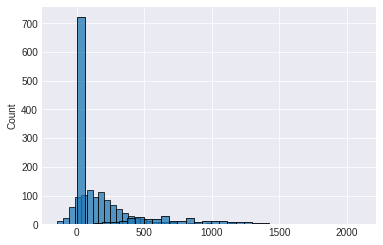

In [ ]:
sns.histplot(predictions)
sns.histplot(y_test.values)

This is not good approach so I am coming back to using the data about binary variable

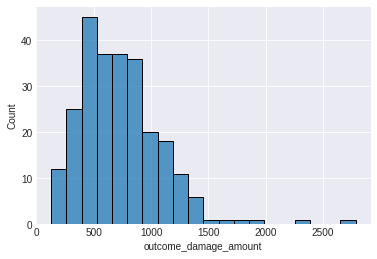

In [ ]:
sns.histplot(y_test)


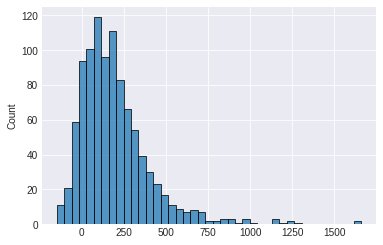

In [ ]:
sns.histplot(predictions)


In [ ]:
sns.histplot(
    planets, x="year", y="distance",
    bins=30, discrete=(True, False), log_scale=(False, True),
    cbar=True, cbar_kws=dict(shrink=.75),
)

#  Results  


Results were computed  taking  combining all the results from  previous stages 

# Predicting profit

##  Hold-out prediction for combined pipeline

In [ ]:
import joblib
from io import BytesIO
import pickle
import requests
mLink = 'https://github.com/phuycke/ML-in-Python/blob/main/models/random_search_gbm_profit.pkl?raw=true'
mfile = BytesIO(requests.get(mLink).content)
model_profit = joblib.load(mfile)



In [ ]:
model_profit.fit(X_train, y_train)
print('R2: %.3f' % model_profit.score(X_train, np.array(y_train).reshape(-1,1)))
model_profit.fit(X_test, y_test)

print('R2: %.3f' % model_profit.score(X_test, np.array(y_test).reshape(-1,1))) #Here we are using the "holdout" set already

R2: 0.703
R2: 0.965


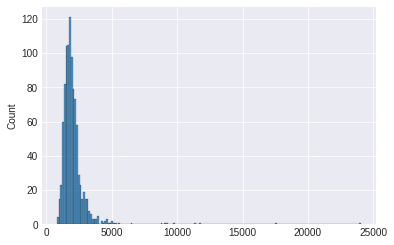

In [ ]:
predict_profit = model_profit.predict(X_test)
sns.histplot(predict_profit)


## Predicting damage

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
Xtest_log= X_test[final_list]
Xtrain_log = X_train[final_list]
len(final_list)
logreg = LogisticRegression()
logreg.fit(Xtrain_log,y_train)
binary_predict_profit = logreg.predict(Xtest_log)


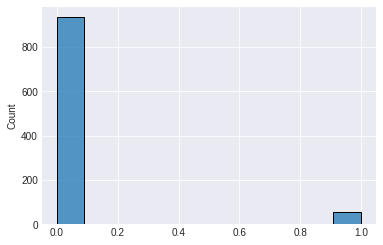

In [ ]:
sns.histplot(binary_predict_profit)

In [ ]:
logproba = logreg.predict_proba(X_test[final_list])
 sklearn.preprocessing.binarize(X, *, threshold=0.5, copy=True)[source]¶

array([[0.93877895, 0.06122105],
       [0.74407427, 0.25592573],
       [0.7679556 , 0.2320444 ],
       ...,
       [0.87588063, 0.12411937],
       [0.42251481, 0.57748519],
       [0.729333  , 0.270667  ]])

### Predict binary damage

> Indented block



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_train['outcome_damage_inc'], test_size=0.2,  random_state=48)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train[final_list ], y_train)
print('Train accuracy: {:.2f}'.format(logreg.score(X_train[final_list], y_train)))
print('Test accuracy: {:.2f}'.format(logreg.score(X_test[final_list], y_test)))
logreg.predict_proba(X_test[final_list])

In [ ]:
data_dam = data_train[data_train.outcome_damage_inc == 1]
X_train, X_test, y_train, y_test = train_test_split(data_dam.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1),
                                                    data_dam['outcome_damage_amount'], test_size=0.2,  random_state=48)
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
X = X_train[damage_amount_variables]
y = y_train
X_test_short = X_test[damage_amount_variables]
model.fit(X,y)

[16:30:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, eta=0.1, max_depth=7, n_estimators=1000,
             subsample=0.7)

# Making final scoring of the candidates for hotel guests 

# Prediction of the score

For predicting the score I may train the data on whole train dataset, without  withoulding parts of it.

In [ ]:
data_train

,outcome_profit,outcome_damage_inc,outcome_damage_amount,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,gender_M,client_segment_0.0,client_segment_1.0,client_segment_2.0,client_segment_3.0,client_segment_4.0,sect_empl_0.0,sect_empl_1.0,sect_empl_2.0,sect_empl_3.0,sect_empl_4.0,profitpernight
0,1791.66,0,0.00,-0.252204,-0.235716,-0.080882,1.301738,6.332496,2.566910,0,0,0,0,1,0,-0.983939,1,-0.727748,1,-0.574737,-0.484916,0,1,0,0,1,1,0,1.288844,1.935413,1.374007,1.398465e+00,0,-0.30462,-0.066999,4.777023,-0.301437,0,0,0,-0.235107,3.240857e+00,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,2.360180e+00,-2.812824,0.000000,-5.155797e-16,1,0,1,0,0,0,0,1,0,0,0,-0.446616
1,1672.78,1,829.66,-0.247235,-0.230252,-0.347972,-0.256938,-0.398615,-0.561289,0,0,0,1,1,0,0.312238,1,-0.527791,0,-2.413230,-1.658641,0,0,0,0,0,0,0,-1.199249,-0.460687,-1.673853,-1.694566e+00,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,1.623410e+00,1,0,1,0,0,0,1,0,0,0,0,-0.115700
2,1001.40,0,0.00,-0.245417,-0.227862,-0.349554,-0.256938,-0.398615,-0.561289,0,0,0,1,0,0,-1.632027,1,-0.327835,0,-0.032574,-1.473316,0,1,0,0,1,0,0,-1.199249,-0.460687,-1.212262,-1.206192e+00,0,-0.30462,-0.066999,-0.609490,-0.301437,0,0,0,0.000000,7.448483e-16,-1.884848e+00,-2.699639e+00,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,-2.739122,-1.982739e+00,1,0,1,0,0,0,1,0,0,0,0,-0.231400
3,1785.59,0,0.00,-0.252204,-0.235716,-0.347444,-0.256938,-0.398615,-0.725932,0,0,0,0,0,0,-0.011806,1,0.471989,1,-0.077555,-0.484916,0,1,0,0,1,0,0,1.288844,1.935413,0.000000,-2.891751e-16,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,2.584963e+00,-3.872809e-16,0.000000,0.000000,-5.155797e-16,0,0,1,0,0,0,1,0,0,0,0,-0.115087
4,3140.74,0,0.00,0.216113,0.115296,-0.041496,1.120946,1.845089,2.347387,0,0,1,0,1,0,-0.659895,0,-0.727748,1,-0.474431,-1.164441,0,1,0,0,1,0,0,0.044798,-0.460687,0.545858,5.845096e-01,0,-0.30462,-0.066999,-0.689094,0.782642,1,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-1.117528e+00,1.771561e+00,-6.532348e-02,0.280081,0.000000,-5.155797e-16,0,0,0,1,0,0,1,0,0,0,0,0.473282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,2172.82,0,0.00,-0.208936,-0.217960,-0.332674,-0.256938,-0.398615,-0.725932,0,0,0,0,1,0,1.284370,1,-0.327835,0,-0.206348,-1.473316,1,1,0,0,1,0,0,0.044798,-0.460687,-0.533451,-5.550280e-01,0,-0.30462,-0.066999,-0.715628,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,1.713795e+00,-1.326337e+00,2.309840e+00,-2.886235,-1.290270,-8.238897e-01,0,0,1,0,0,0,1,0,0,0,0,0.263252
4943,1057.83,0,0.00,-0.252204,-0.235716,-0.358873,-0.256938,-0.398615,-0.725932,0,0,0,0,0,0,0.312238,1,-0.127879,0,-0.965615,1.491883,0,0,0,0,0,1,0,-1.199249,-0.460687,0.518706,5.031141e-01,0,-0.30462,-0.066999,-0.264541,-0.301437,0,1,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,-5.155797e-16,1,0,1,0,0,0,1,0,0,0,0,-0.389490
4944,188.77,0,0.00,-0.250750,-0.234008,-0.280100,-0.256938,-0.398615,-0.177125,0,0,0,1,0,0,-1.632027,0,0.471989,1,-0.718823,0.997684,1,0,0,0,1,0,1,-1.199249,-0.460687,-0.689578,-7.178191e-01,0,-0.30462,-0.066999,0.982583,-0.301437,0,1,0,0.000000,7.448483e-16,-5

In [ ]:
data_train = pd.read_csv('https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/processed/data_train_scaled.csv',index_col=[0])

data_train_score = data_train.drop(['outcome_profit', 'outcome_damage_inc', 'outcome_damage_amount'],1)
score = pd.read_csv('https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/processed/score_scaled.csv',index_col=[0])
score


,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,gender_M,client_segment_0.0,client_segment_1.0,client_segment_2.0,client_segment_3.0,client_segment_4.0,sect_empl_0.0,sect_empl_1.0,sect_empl_2.0,sect_empl_3.0,sect_empl_4.0,profitpernight
0,0.406275,1.239353,0.875469,-0.256938,-0.398615,1.030251,0,0,1,0,0,0,1.608414,1,0.072077,1,0.189478,-0.176041,1,1,0,0,1,1,0,1.288844,1.935413,2.046030,2.049629,0,-0.30462,-0.066999,0.611099,3.111150,1,0,1,0.257097,-6.941060e-01,-5.311017e-01,1.786628e+00,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,-5.155797e-16,0,0,0,1,0,0,0,1,0,0,0,-0.323426
1,0.203871,-0.232642,-0.037100,-0.256938,-0.398615,2.018103,0,0,0,1,0,0,0.312238,1,-0.127879,0,0.540174,-0.176041,0,1,0,0,1,0,0,0.044798,-0.460687,-0.676001,-0.636424,0,-0.30462,-0.066999,-0.662559,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,-5.155797e-16,1,0,1,0,0,0,0,1,0,0,0,0.245285
2,-0.139367,-0.207717,0.093719,0.459211,4.088792,1.908342,0,0,0,1,1,0,1.284370,1,1.071857,1,0.727143,-0.423141,1,1,0,0,1,1,0,1.288844,0.737363,-0.302655,-0.310841,0,-0.30462,-0.066999,5.121972,-0.301437,0,0,0,-3.425583,6.210118e-01,-7.853804e-16,7.500248e-16,-1.649903e+00,1.497563e+00,2.220070e+00,-0.762301,0.000000,-5.155797e-16,1,0,1,0,0,0,1,0,0,0,0,-0.443696
3,0.017345,0.034372,-0.271133,-0.256938,-0.398615,-0.725932,0,0,0,1,1,0,-0.659895,1,-0.127879,0,-0.525258,1.306559,1,1,0,0,0,0,0,-1.199249,-0.460687,0.688408,0.665905,0,-0.30462,-0.066999,-0.689094,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,-5.155797e-16,1,0,1,0,0,0,1,0,0,0,0,0.117742
4,-0.165061,-0.159913,-0.285727,-0.256938,-0.398615,-0.725932,0,0,1,0,0,0,-0.335850,1,-1.127660,0,0.517534,1.121234,0,1,0,0,1,1,0,-1.199249,-0.460687,0.973509,0.991487,0,-0.30462,-0.066999,0.133477,-0.301437,0,0,0,0.000000,7.448483e-16,-7.853804e-16,7.500248e-16,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,-5.155797e-16,0,0,0,1,0,0,1,0,0,0,0,-0.410218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,-0.180332,-0.161962,0.726715,1.679121,2.966940,1.249774,0,0,0,1,1,0,-0.335850,1,-0.527791,0,1.290895,-0.299591,1,1,0,0,1,0,0,-1.199249,0.737363,-0.214410,-0.229446,0,-0.30462,-0.066999,0.266150,-0.301437,0,0,0,-1.353475,1.077550e+00,-7.853804e-16,7.500248e-16,1.663943e+00,2.745395e+00,-3.872809e-16,0.000000,-1.639915,1.684604e+00,1,0,1,0,0,0,1,0,0,0,0,-0.295909
492,0.458634,0.481332,-0.092136,-0.256938,-0.398615,-0.725932,0,0,0,0,1,0,-0.011806,0,0.471989,0,0.703303,-0.052491,1,1,0,0,1,0,1,0.044798,-0.460687,1.068542,1.072883,0,-0.30462,-0.066999,-0.715628,2.735247,1,0,0,0.000000,7.448483e-16,-5.577104e-01,1.142904e+00,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,-5.155797e-16,0,0,0,1,0,0,1,0,0,0,0,0.821880
493,-0.000835,-0.162645,-0.201327,-0.256938,-0.398615,1.688819,0,0,0,0,0,0,0.312238,1,-0.927704,0,-1.313763,-0.423141,1,1,0,0,1,1,0,0.044798,-0.460687,0.681620,0.665905,0,-0.30462,-0.066999,-0.317610,1.500131,1,0,0,2.339503,1.091995e+00,1.403154e+00,-9.857347e-01,-3.785955e-16,3.656151e-16,-3.872809e-16,0.000000,0.000000,-5.155797e-16,1,0,1,0,0,0,0,1,0,0,0,-0.338252
494,-0.220086,-0.235716,0.009671,0.994567,1.845089,0.371682,0,0,0,1,1,0,0.312238,1,-1.127660,1,0.565663,0.132834,0,1,0,0,1,0

In [ ]:
import joblib
import seaborn as sns
from io import BytesIO
import pickle
import requests
mLink = 'https://github.com/phuycke/ML-in-Python/blob/main/models/random_search_gbm_profit.pkl?raw=true'
mfile = BytesIO(requests.get(mLink).content)
model_profit = joblib.load(mfile)
model_profit.fit(data_train_score, data_train['outcome_profit'])



GradientBoostingRegressor(learning_rate=0.05111771456150691, max_depth=5,
                          max_features='auto', n_estimators=430, subsample=0.8)

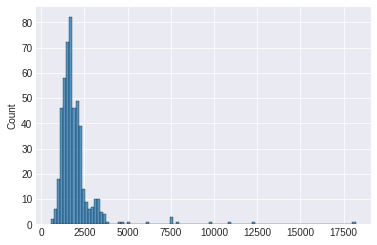

In [ ]:

predict_profit_score = model_profit.predict(score)
sns.histplot(predict_profit_score )


In [ ]:
predict_profit_score

array([ 1290.00751386,  2408.14553628,  1662.40426001,  2186.46885069,
        1369.61280455,  1284.42029345,  1449.33072625,  3248.14541589,
        3690.9500998 ,   921.80421635,  1294.56539478,  1569.78113816,
        1570.04871897,  1193.67053272,  1703.91479815,  2003.34555598,
        3674.1218149 ,  1197.64720214,  1515.76277551,  2111.13411636,
         703.46062214,  2402.66935303,  1160.09638476,  1405.55177373,
        1653.4676853 ,  1739.13930592,  1805.74411419,  1250.90345997,
        1445.49965827,  1642.44469972,  1752.25356821,  4484.68232664,
        1327.55921774,  1893.13121965,  1188.79005553,  1419.93196276,
        1539.32051598,  1932.87758743,  2278.86449726,  1141.04747653,
        1116.0020164 ,  1658.94561958,  1005.97326334,  2158.65640735,
        1554.39221933,  2323.01405599,  1627.29800831,  1156.95797713,
        7861.43040398,  1496.45075688,  1906.42812954,  1574.21622407,
        2472.60976342,  1637.69355944,  2166.82676495,  1626.75132309,
      

#### Predicting the binary damages

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
important_binary_variables = get_meaningful_variables(data_train, feature = 'outcome_damage_inc' )
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(data_train['outcome_damage_inc'])
logreg.fit(data_train_score[important_binary_variables],  encoded)


['gender_M',
 'score3_neg',
 'score5_pos',
 'age',
 'score2_pos',
 'profit_am',
 'client_segment_2.0',
 'crd_lim_rec',
 'fam_adult_size',
 'damage_am',
 'spa_ic',
 'children_no',
 'score5_neg',
 'client_segment_4.0',
 'insurance_ic',
 'sect_empl_2.0',
 'prev_all_in_stay',
 'damage_inc',
 'bar_no',
 'shop_use',
 'cab_requests',
 'score1_neg',
 'retired',
 'marketing_permit',
 'tenure_mts',
 'score2_neg',
 'urban_ic',
 'score1_pos',
 'credit_use_ic',
 'lactose_ic',
 'sport_ic']

LogisticRegression()

In [ ]:
predict_binary = logreg.predict(score[important_binary_variables])
len(predict_binary)


496

In [ ]:
sum(predict_binary)

20

the final list of selected clients, with their predicted revenue, predicted damage status
(yes/no), predicted damage costs, and overall predicted revenue, as csv.

In [ ]:
score_raw = pd.read_csv( 'https://raw.githubusercontent.com/phuycke/ML-in-Python/main/data/raw/score.csv')
mask, data_nan, missing_data = fast_check_data(score_raw,  ax = 1, treshold = 40)
score_raw = score_raw[~mask]
indices = score_raw.index


In the end I will use GradientBoostingRegressor but on thel limited amount of variables

In [ ]:
damageam_preds = gbm_damageam.predict(score[important_damage_variables])
predict_amount = damageam_preds * predict_binary
predict_amount 

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  808.02576739,    0.        ,    0.        ,
        959.40846724,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        , 1154.87630097,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        , 1077.86464973,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     

In [119]:

frame = { 'Client number' : indices, 'profit_preds': predict_profit_score, 'Predicted damage status': predict_binary , "predict_amount" : predict_amount }
  
result = pd.DataFrame(frame)
pd.Series(result.profit_preds - result.predict_amount)
result["overal_predicted_amount"] = pd.Series(result.profit_preds - result.predict_amount)
result = result.sort_values(by=['overal_predicted_amount'], ascending = False)
final_frame = result.head(200)
final_frame


,Client number,profit_preds,Predicted damage status,predict_amount,overal_predicted_amount
81,81,18196.130389,0,0.000000,18196.130389
78,78,12355.166901,1,1160.472732,11194.694169
427,431,10902.544894,0,0.000000,10902.544894
84,84,9821.002857,0,0.000000,9821.002857
48,48,7861.430404,0,0.000000,7861.430404
...,...,...,...,...,...
154,154,1866.717488,0,0.000000,1866.717488
261,261,1866.416991,0,0.000000,1866.416991
453,457,1862.675574,0,0.000000,1862.675574
421,425,1852.123697,0,0.000000,1852.123697


In [120]:
from google.colab import files
final_frame.to_csv('final_frame.csv') 
files.download('final_frame.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pred_all = pd.Series(profit_preds - [x[1] for x in damagebin_preds] * damageam_preds)
pred_allexp_profit = pd.Series(profit_preds - [x[1] for x in damagebin_preds] * damageam_preds)
exp_profit.index = score.index
score['exp_profit'] = exp_profit

4947

Better would be to use   the proabilities of binary damages (our model is too restrictive here)

# Discussion of the results and about project

Overal we improved all metrics from the example notebook. Maybe better solution wouold to predict overall amount from the start (as good or bad client than  doing it part by parr)


The project was an enriching learning experience in several aspects. First of all, it showed us how dificult it is to work in a team while at the distance. While planned online meetings were good, the spontaneus discussions that people tend to have with their coworkers were missing. 

On the other hand, version control was a real problem. We tried to use Github for a more collaborative experience, as we were interested in learning and cooperation, but sometimes it lead to version problems. At the end we turned to Colaboratory from Google, which was nice, but it was difficult to code at the same time (problems with saving) and it was slow.
In the case of the technical aspect it also allowed us to improve our programming and statistical skills. It made clearer that there were things that we understood during class, but that were difficult to use while creating something from zero.

The biggest limitation that we faced was time. The three of us had fulltime jobs as assistants and PhD students, and the project was carried out during the difficult moment of the final examinations of the students and during the PhD evaluations, when there is an increase of work load.
Finally, we would like to further try the second approach that we mentioned in our introduction, that we couldn’t finish because of the time restriction. Also, for the profit model, it would be interesting to reduce the quantity of variables to carry out the GAM model and see if it converges or using Extreme gradient boosting.
